## Introdução

Uma **série temporal** é um conjunto de observações ($y_t$) registradas em intervalos de tempo específicos ($t$). No contexto deste trabalho, a série temporal em estudo é o `volume` semanal. O objetivo central é modelar essa variável e gerar previsões futuras, o que requer a especificação da distribuição conjunta de uma sequência de variáveis aleatórias $\{Y_t\}$.

Como na prática temos acesso apenas a uma realização dessa série, a modelagem se concentra nos momentos de primeira e segunda ordem (média $E[Y_t]$ e covariância $E[Y_{t+h}Y_t]$). A natureza temporal dos dados exige a consideração da dependência temporal, ou seja, a correlação entre observações ao longo do tempo. Se um modelo não consegue capturar completamente essa dependência, ela pode restar nos resíduos.

Para modelar o `volume`, exploramos dois grupos principais de métodos, cujos resultados serão detalhados nas seções seguintes:

1.  **Modelos Simples de Previsão (*Baselines*)**: Estes métodos estabelecem um padrão mínimo de desempenho.
2.  **Modelos de Regressão Linear Múltipla**: Utilizamos a estrutura do Modelo Linear Padrão ($y_t = \beta_0 + \beta_1x_{1t} + \ldots + \epsilon_t$) para incorporar covariáveis criadas a partir de `week` e `volume`, como tendência, *lags*, médias móveis e sazonalidade. A estimação dos coeficientes ($\hat{\beta}$) é realizada pelo método de Mínimos Quadrados (OLS).

## Carregando as bibliotecas e os dados

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.api import ARIMA, SARIMAX
from scipy.stats import norm

In [139]:
# Carregando e ajustando os dados
data = pd.read_csv("data.csv")
data["week"] = pd.to_datetime(data["week"])
data_series = data.set_index("week")["volume"]

print(data_series.head())

week
2022-10-31    0.33
2022-11-07    0.47
2022-11-14    0.32
2022-11-21    1.69
2022-11-28    1.23
Name: volume, dtype: float64


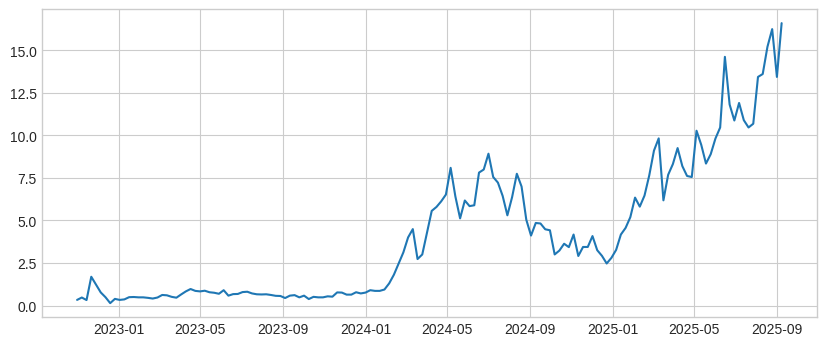

In [140]:
# Exibindo os dados
plt.figure(figsize = (10, 4))
plt.plot(data_series)
plt.show()

## Discussão sobre Métricas e Métodos de Avaliação

As métricas de avaliação vão ser usadas para comparar o desempenho fora da amostra (*out-of-sample*) dos modelos, utilizando os erros de previsão ($e_{T+h} = y_{T+h} - \hat{y}_{T+h|T}$). Utilizaremos métricas de previsão pontual e distribucional.

### A. Métricas de Previsão Pontual

As métricas pontuais avaliam a precisão da estimativa média:

*   **RMSE (Raiz do Erro Quadrático Médio)**: É o critério de ordenação principal. O RMSE dá maior peso aos erros grandes e é minimizado pela média.
*   **MAE (Erro Absoluto Médio)**: É fácil de interpretar, pois representa o erro médio na mesma escala dos dados.
*   **MASE (Erro Absoluto Médio Escalado)**: É essencial para comparar a performance dos modelos de Regressão Linear Múltipla com os Baselines. O MASE é livre de escala e um valor menor que 1 indica que o modelo é melhor que o baseline ingênuo sazonal.
*   **MAPE (Erro Percentual Absoluto Médio)**: Mostra o erro médio percentual, facilitando comparações relativas.

### B. Métricas de Previsão Distribucional

A previsão distribucional é uma abordagem mais completa, estimando a distribuição completa dos resultados futuros. Todas as métricas serão calculadas assumindo a normalidade da distribuição.

*   **Winkler Score**: Avalia a qualidade de um intervalo de previsão ($95\%$ no trabalho). Ele penaliza a falta de calibração (quando o valor real cai fora) e favorece intervalos estreitos (nitidez). Um valor menor indica um intervalo mais preciso.
*   **Erro de Quantil (*Quantile Score*)**: Avalia a precisão da previsão para um quantil específico (e.g., 0.1, 0.5, 0.9). Quando $p=0.5$ (mediana), ele se reduz ao MAE.
*   **CRPS (Continuous Ranked Probability Score)**: É uma métrica abrangente que avalia a precisão da distribuição de previsão como um todo. Um valor menor indica uma distribuição mais bem calibrada e nítida.

## Avaliando a decomposição da série em tendência e sazonalidade

Primeiramente, vamos avaliar a existência de padrões de tendência e de sazonalidade nessa série de dados. Para isso, calculamos suas autocorrelações, que estão exibidas abaixo.

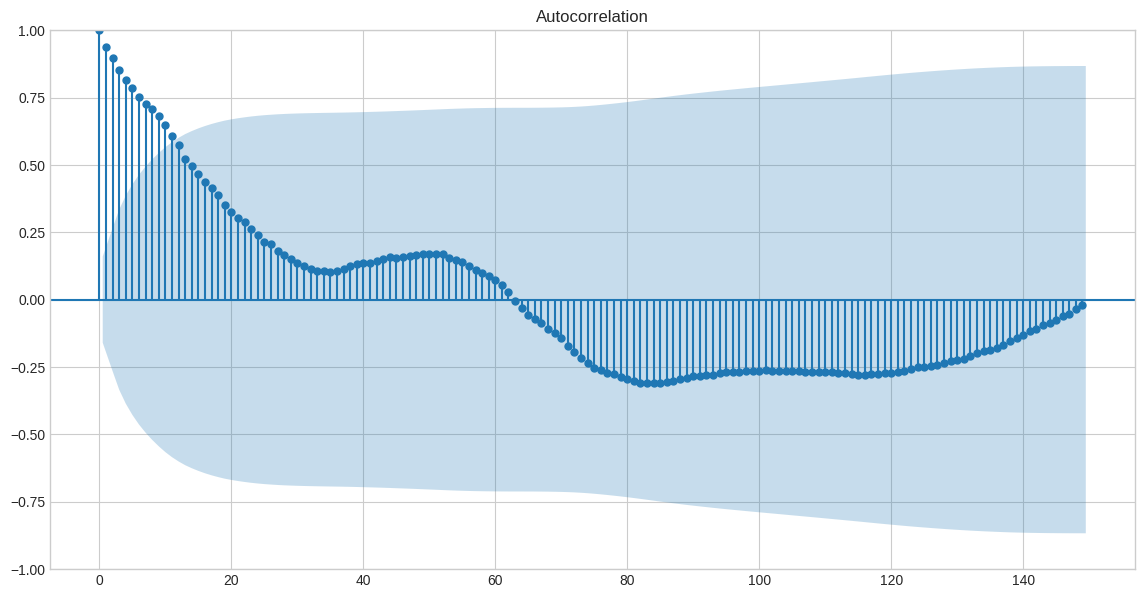

In [141]:
# Calculando e exibindo a função de autocorrelação
plot_acf(data_series, lags = 149)
plt.show()

Analisando o gráfico, podemos concluir que há um forte indício da existência de tendência nesse conjunto de dados, o que pode ser constatado pela alta correlação entre valores temporalmente próximos que diminui lentamente até valores maiores de lag. Por outro lado, não há sinal de sazonalidade, já que não existem picos significativos de autocorrelação além do presente em lags menores.

Isso pode ser mais profundamente testado por meio da efetiva decomposição desse dado nas três componentes temporais (tendência, sazonalidade e resíduo) e da observação do comportamento dos resíduos resultantes. Nos gráficos abaixo, realizamos a decomposição com janelas temporais de 4 semanas (ciclo mensal) e de 52 semanas (ciclo anual).

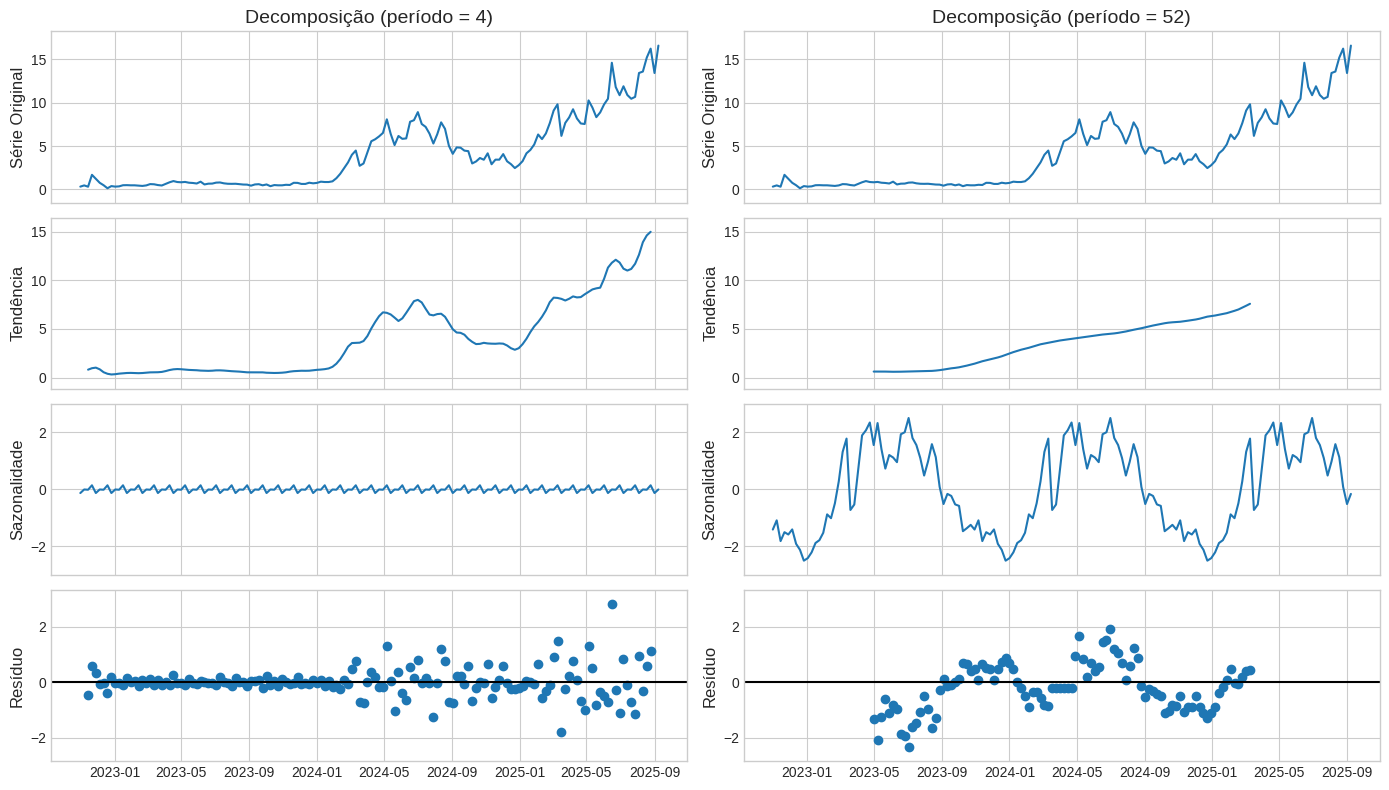

In [142]:
# Fazendo a decomposição da série nas duas janelas de interesse
decomposition_4_weeks = seasonal_decompose(data_series, model = "additive", period = 4)
decomposition_52_weeks = seasonal_decompose(data_series, model = "additive", period = 52)

fig, axes = plt.subplots(4, 2, figsize=(14, 8), sharex=True)

components_4 = [decomposition_4_weeks.observed,
                decomposition_4_weeks.trend,
                decomposition_4_weeks.seasonal,
                decomposition_4_weeks.resid]

components_52 = [decomposition_52_weeks.observed,
                 decomposition_52_weeks.trend,
                 decomposition_52_weeks.seasonal,
                 decomposition_52_weeks.resid]

min_data = min(data_series)
max_data = max(data_series)
min_trend = min(min(components_4[1].dropna()), min(components_52[1].dropna()))
max_trend = max(max(components_4[1].dropna()), max(components_52[1].dropna()))
min_seasonal = min(min(components_4[2].dropna()), min(components_52[2].dropna()))
max_seasonal = max(max(components_4[2].dropna()), max(components_52[2].dropna()))
min_residuals = min(min(components_4[3].dropna()), min(components_52[3].dropna()))
max_residuals = max(max(components_4[3].dropna()), max(components_52[3].dropna()))

titles = ['Série Original', 'Tendência', 'Sazonalidade', 'Resíduo']
lims = [(min_data, max_data), (min_trend, max_trend), (min_seasonal, max_seasonal), (min_residuals, max_residuals)]

for i in range(4):
    if i < 3:
        axes[i, 0].plot(components_4[i])
    else:
        axes[i, 0].scatter(data_series.index, components_4[i])
        axes[i, 0].axhline(0, color = "black")

    axes[i, 0].set_ylim((lims[i][0] - 0.1*(lims[i][1]-lims[i][0]), lims[i][1] + 0.1*(lims[i][1]-lims[i][0])))
    axes[i, 0].set_ylabel(titles[i], fontsize = 12)

for i in range(4):
    if i < 3:
        axes[i, 1].plot(components_52[i])
    else:
        axes[i, 1].scatter(data_series.index, components_52[i])
        axes[i, 1].axhline(0, color = "black")

    axes[i, 1].set_ylim((lims[i][0] - 0.1*(lims[i][1]-lims[i][0]), lims[i][1] + 0.1*(lims[i][1]-lims[i][0])))
    axes[i, 1].set_ylabel(titles[i], fontsize = 12) 
    
# 5. Adicione títulos específicos para as colunas e remova títulos individuais do subplot
axes[0, 0].set_title('Decomposição (período = 4)', fontsize = 14)
axes[0, 1].set_title('Decomposição (período = 52)', fontsize = 14)

# 6. Ajuste o layout
plt.tight_layout()
plt.show()

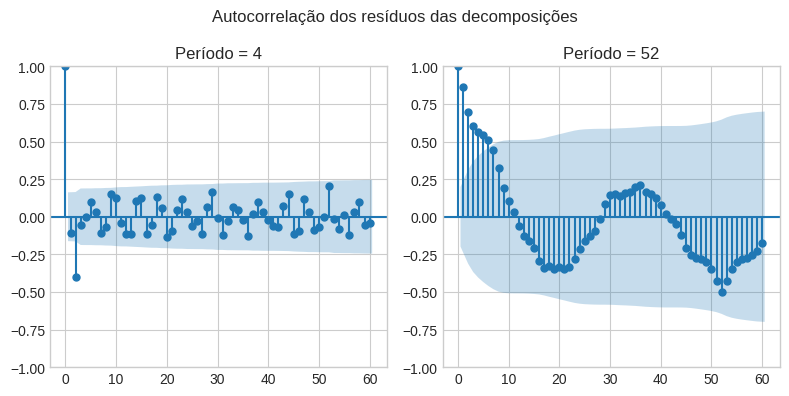

In [143]:
# Pegando os resíduos não nulos das decomposições e plotando suas ACFs
residuals_4_weeks = decomposition_4_weeks.resid.values
residuals_4_weeks = residuals_4_weeks[~np.isnan(residuals_4_weeks)]

residuals_52_weeks = decomposition_52_weeks.resid.values
residuals_52_weeks = residuals_52_weeks[~np.isnan(residuals_52_weeks)]

fig, axes = plt.subplots(1, 2, figsize = (8, 4))

plot_acf(residuals_4_weeks, ax = axes[0], lags = 60)
plot_acf(residuals_52_weeks, ax = axes[1], lags = 60)

fig.suptitle("Autocorrelação dos resíduos das decomposições")

axes[0].set_title("Período = 4")
axes[1].set_title("Período = 52")

plt.tight_layout()
plt.show()

Pode-se observar que, com um período de 4 semanas (1 mês), o valor absoluto da sazonalidade é muito baixo (entre -0.1 e 0.1), sendo pouco significativo para o dado como um todo. Além disso, seus resíduos são maiores ao final da série, indicando uma heterocedasticidade não desejável.

Já com relação ao período de 52 semanas (1 ano), apesar da componente sazonal ser mais significativa, os resíduos claramente apresentam correlação, não podendo ser caracterizados como ruído branco.

Portanto, em ambos os casos, vemos que não é adequada a decomposição da série utilizando uma componente sazonal.

## Selecionando o modelo a ser ajustado

Como foi inferida, na análise anterior, a existência de tendência mas a inexistência de sazonalidade no conjunto de dados em estudo, então, a seguir, analisaremos o ajuste de modelos da forma:

$$
f(\text{volume}_t) = \beta_0 + \beta_1 t + \epsilon_t
$$

onde $t$ corresponde à covariável de tendência do modelo e $f$ a uma possível transformação.

Ao observar o visual da série de dados, é possível perceber um padrão exponencial na variável de volume, o que sugere uma transformação logarítmica dos dados. Com isso em mente, vamos ajustar os seguintes dois modelos e analisar a qualidade de seus ajustes:

$$
\text{1. volume}_t = \beta_0 + \beta_1 t + \epsilon_t \\
\text{2. } \log(\text{volume}_t) = \beta_0 + \beta_1 t + \epsilon_t
$$

In [144]:
# Covariável t
time_covariate = np.arange(data_series.size)

# Criando os dados lineares e logarítmicos
X = sm.add_constant(time_covariate)
original_y = data_series
log_y = np.log(data_series)

# Ajustando os modelos
ols_model_linear = sm.OLS(original_y, X).fit()
ols_model_exponential = sm.OLS(log_y, X).fit()

In [145]:
print("R² ajustado:")
print("-> Modelo com y linear:     ", ols_model_linear.rsquared_adj)
print("-> Modelo com y logarítmico:", ols_model_exponential.rsquared_adj)

R² ajustado:
-> Modelo com y linear:      0.7205984579494695
-> Modelo com y logarítmico: 0.8141538995583324


 Utilizando o Coeficiente de Determinação Ajustado ($R^2$ ajustado), que mede a proporção da variabilidade de $y_t$ explicada pelo modelo, penalizando o número de parâmetros.

Como observado, o modelo com a variável `volume` transformada por logaritmo apresentou um ajuste melhor e, portanto, será o modelo considerado para as próximas análises.

## Análise do ajuste do modelo

TODO: Escrever

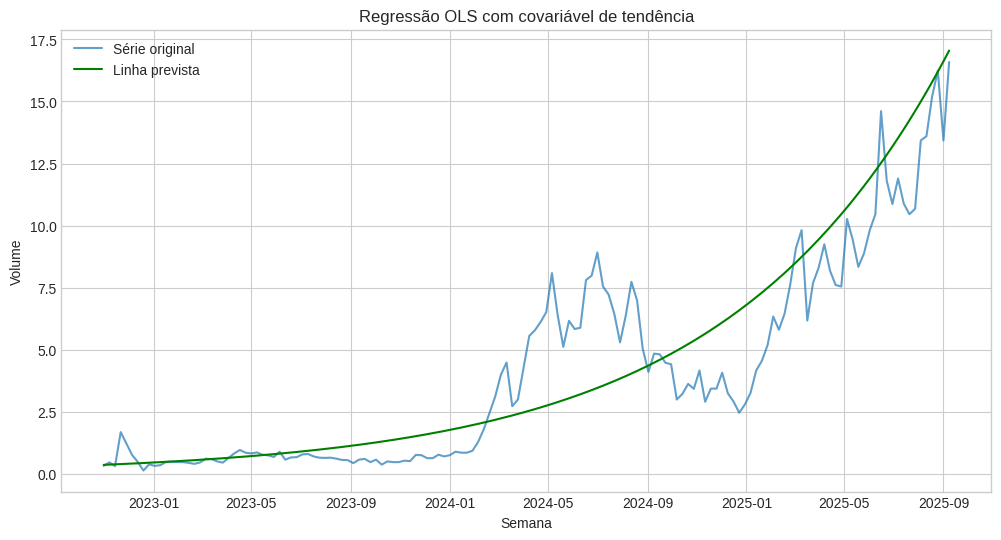

In [146]:
# Variância residual do ajuste
mse_resid = ols_model_exponential.mse_resid

# Fator de correção da transformação da predição para a escala original
correction_factor = np.exp(mse_resid / 2)

# Calculando a predição na escala original
predicted_original_scale_corrected = np.exp(ols_model_exponential.predict(X)) * correction_factor

plt.figure(figsize = (12, 6))
plt.plot(data_series.index, data_series, label = 'Série original', alpha = 0.7)
plt.plot(data_series.index, predicted_original_scale_corrected, color = 'green', linestyle = '-', label = 'Linha prevista')
plt.title('Regressão OLS com covariável de tendência')
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.legend()
plt.show()

# Baselines

Os modelos *baselines* foram utilizados para estabelecer um padrão mínimo de desempenho que os modelos mais complexos (Regressão Linear Múltipla) precisam superar. Todos os *baselines* foram ajustados no conjunto de treino e avaliados no conjunto de teste.

Os quatro *baselines* utilizados são: Média, Random Walk without Drift, Random Walk with Drift e Método Ingênuo Sazonal.

## Dividindo em treino e teste

In [147]:
ts_volume = data['volume']

percent_data = int((len(ts_volume)*0.2 ))
# Divisão cronológica dos dados
train = ts_volume.iloc[:-percent_data]
test = ts_volume.iloc[-percent_data:]

## Média
Começamos com o método mais ingênuo, o qual é estimar todos os outroso como a média do treino. 

In [148]:
predictions = {}

mean_forecast = np.mean(train)
predictions['Média'] = pd.Series(mean_forecast, index=test.index)

## Random Walk without Drift
O próximo método que temos é o Random Walk without drift, o qual consiste em simplesmente pegar o último valor e prever todos os próximos valores como ele.

In [149]:
random_naive_pred = train.iloc[-1]
predictions['Ingênuo'] = pd.Series(random_naive_pred, index=test.index)

## Random Walk with Drift
O método tende a prever o úlitmo valor, mas adiciona a tendência dos dados. Como por exemplo, se os dados tendem a ter uma queda no treino, o modelo vai decrescer essa taxa para as próximas previsões. Caso haja um crescimento o modelo acresce a taxa. 

In [150]:
T = len(train)
drift_value = (train.iloc[-1] - train.iloc[0]) / (T - 1)
h_steps = np.arange(1, len(test) + 1)
drift_forecast = train.iloc[-1] + h_steps * drift_value
predictions['Desvio (Drift)'] = pd.Series(drift_forecast, index=test.index)

## Método Ingênuo Sazonal
No método ingênuo sazonal, o que fazemos é assumir que há sazonalidade nos dados e apenas assumir que o próximo valor será o mésmo do último período que ele apareceu. como o modelo está em semanas, umas sazonalidade de 52 faz sentido. Podemos utilizar a classe sarimax do statsmodel que nós da essa previsão sem maiores esforços

In [151]:
m = 52
model_snaive = SARIMAX(train, order=(0, 0, 0), seasonal_order=(0, 1, 0, m))
fit_snaive = model_snaive.fit(disp=False)
predictions['Ingênuo Sazonal'] = fit_snaive.forecast(steps=len(test))

## Plot Pontual
podemos plotar pontualmente como foram as previsões de cada modelo

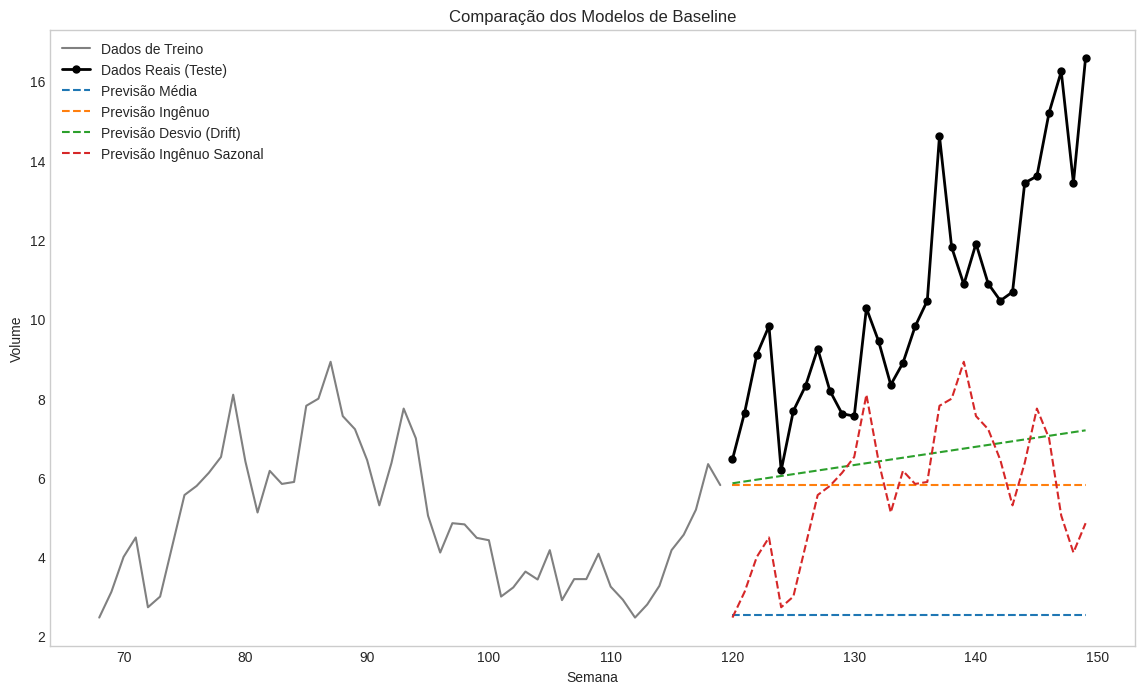

In [152]:
plt.figure(figsize=(14, 8))
plt.plot(train.iloc[-52:], label='Dados de Treino', color='gray')
plt.plot(test, label='Dados Reais (Teste)', color='black', linewidth=2, marker='o', markersize=5)

for name, forecast in predictions.items():
    plt.plot(forecast, label=f'Previsão {name}', linestyle='--')

plt.title('Comparação dos Modelos de Baseline')
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.legend(loc='upper left')
plt.grid(False)
plt.show()

## Avaliando a previsão distribucional

Além de uma previsão pontual, uma abordagem mais completa é gerar uma **previsão distribucional**, que estima a distribuição de probabilidade completa dos possíveis resultados futuros. Para avaliar essa abordagem, usamos métricas específicas.

### Erro de Quantil (Quantile Score)

Esta métrica avalia a precisão da previsão de um quantil específico \(p\).  
A fórmula é:

\[
Q_{p,t}=
\begin{cases}
2(1-p)(\hat{q}_{p,t}-y_t), & \text{se } y_t < \hat{q}_{p,t} \\
2p(y_t-\hat{q}_{p,t}), & \text{se } y_t \ge \hat{q}_{p,t}
\end{cases}
\]

A função penaliza de forma **assimétrica**.  
- Para um quantil baixo (e.g., \(p=0.1\)), esperamos que o valor real seja maior que a previsão na maioria das vezes.  
- A métrica penaliza mais fortemente os casos em que o valor real fica **abaixo** do previsto do que o contrário.  

Um valor **menor** indica uma melhor estimativa do quantil.  
Quando \(p=0.5\) (a mediana), o Erro de Quantil se torna o **Erro Absoluto Médio (MAE)**.

### Winkler Score

O Winkler Score foi projetado para avaliar um **intervalo de previsão** de \(100(1−\alpha)\%\), considerando tanto sua amplitude quanto sua capacidade de capturar o valor real.  

A fórmula é:

\[
W_{\alpha,t}=
\begin{cases}
(u_{\alpha,t}-l_{\alpha,t})+\frac{2}{\alpha}(l_{\alpha,t}-y_t), & \text{se } y_t < l_{\alpha,t} \\
(u_{\alpha,t}-l_{\alpha,t}), & \text{se } l_{\alpha,t} \le y_t \le u_{\alpha,t} \\
(u_{\alpha,t}-l_{\alpha,t})+\frac{2}{\alpha}(y_t-u_{\alpha,t}), & \text{se } y_t > u_{\alpha,t}
\end{cases}
\]

O score é dado pela **amplitude do intervalo**, somado a uma penalidade caso o valor real \(y_t\) caia fora dele.  

Isso incentiva a criação de intervalos que sejam:
- **Estreitos (precisos)**  
- Mas que ainda contenham a observação real (**calibrados**)  

Um score **menor** indica um intervalo de previsão melhor.


### Continuous Ranked Probability Score (CRPS)

O **CRPS** avalia a precisão da **distribuição de previsão como um todo**.  
Ele mede a diferença entre a **função de distribuição acumulada (FDA)** prevista \(F(x)\) e a FDA empírica do valor observado (uma função degrau em \(y_t\)).

\[
CRPS(F,y_t)=\int_{-\infty}^{\infty}\left(F(x)-\mathbf{1}(x \ge y_t)\right)^2 dx
\]

O CRPS é considerado uma métrica **abrangente**, pois avalia:
- **Calibração** da previsão (se os valores previstos cobrem bem os reais).  
- **Nitidez** da distribuição (se a incerteza não é excessivamente ampla).  

Assim, combina os benefícios de avaliar quantis e intervalos.


In [153]:
# Função para o Winkler Score
def winkler_score(y_true, lower, upper, alpha):
    score = np.where(
        y_true < lower,
        (upper - lower) + (2 / alpha) * (lower - y_true),
        np.where(
            y_true > upper,
            (upper - lower) + (2 / alpha) * (y_true - upper),
            (upper - lower)
        )
    )
    return np.mean(score)

# Função para o Erro de Quantil
def quantile_score(y_true, quantile_forecast, p):
    error = y_true - quantile_forecast
    return np.mean(np.where(error >= 0, p * error, (p - 1) * error))

# Função para o CRPS de uma distribuição Normal
def crps_gaussian(y_true, mu, sigma):
    z = (y_true - mu) / sigma
    crps = sigma * (z * (2 * norm.cdf(z) - 1) + 2 * norm.pdf(z) - 1 / np.sqrt(np.pi))
    return np.mean(crps)

## Análise comparativa dos modelos

In [154]:
alpha = 0.05
intervals = {}
residuals_std = {}

# Desvio Padrões de cada modelo
residuals_std['Média'] = (train - train.mean()).std()
residuals_std['Ingênuo'] = (train - train.shift(1)).std()
residuals_std['Desvio (Drift)'] = (train - (train.shift(1) + drift_value)).std()
residuals_std['Ingênuo Sazonal'] = fit_snaive.resid.std()

# Calculando os intervalos
for name in predictions.keys():
    sigma = residuals_std[name]
    if name == 'Média':
        sigma_h = sigma * np.sqrt(1 + 1/T)
    elif name == 'Ingênuo':
        sigma_h = sigma * np.sqrt(h_steps)
    elif name == 'Desvio (Drift)':
        sigma_h = sigma * np.sqrt(h_steps * (h_steps + 1) / (T - 1))
    elif name == 'Ingênuo Sazonal':
        K = np.floor((h_steps - 1) / m)
        sigma_h = sigma * np.sqrt(K + 1)
    
    intervals[name] = {
        'lower': predictions[name] - 1.96 * sigma_h,
        'upper': predictions[name] + 1.96 * sigma_h
    }


In [155]:
results_list = []

# Denominador para o MASE
scale = np.mean(np.abs(train.diff(m).dropna()))
# Níveis de quantis para avaliar no CRPS
quantiles_to_check = [0.1, 0.25, 0.5, 0.75, 0.9]

# Loop principal sobre cada modelo
for name, forecast in predictions.items():
    # Pega os valores pré-calculados para o modelo atual
    interval = intervals[name]
    sigma = residuals_std[name]
    
    # Calcula as métricas de previsão pontual
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mape = mean_absolute_percentage_error(test, forecast)
    mase = mae / scale
    
    # Calcula o Winkler Score para o intervalo
    winkler = winkler_score(test, interval['lower'], interval['upper'], alpha)
    
    # Calcula o sigma_h (desvio padrão no horizonte de previsão) para o CRPS e o Erro de Quantil
    if name == 'Média':
        sigma_h = sigma * np.sqrt(1 + 1/T)
    elif name == 'Ingênuo':
        sigma_h = sigma * np.sqrt(h_steps)
    elif name == 'Desvio (Drift)':
        sigma_h = sigma * np.sqrt(h_steps * (h_steps + 1) / (T - 1))
    elif name == 'Ingênuo Sazonal':
        K = np.floor((h_steps - 1) / m)
        sigma_h = sigma * np.sqrt(K + 1)
        
    # Calcula o CRPS (usando o sigma_h correto)
    crps = crps_gaussian(test, forecast, sigma_h)

    # Calcula o Erro de Quantil Médio
    avg_quantile_loss = []
    for p in quantiles_to_check:
        quantile_forecast = norm.ppf(p, loc=forecast, scale=sigma_h)
        avg_quantile_loss.append(quantile_score(test, quantile_forecast, p))
    
    # Armazena TODOS os resultados para o modelo atual
    results_list.append({
        'Modelo': name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape * 100,
        'MASE': mase,
        'Winkler Score': winkler,
        'Avg Quantile Score': np.mean(avg_quantile_loss),
        'CRPS': crps
    })

results_df = pd.DataFrame(results_list).set_index('Modelo')
print("\n--- Tabela Comparativa de Métricas (Versão Final Completa) ---")
results_df.round(4)


--- Tabela Comparativa de Métricas (Versão Final Completa) ---


,MAE,RMSE,MAPE (%),MASE,Winkler Score,Avg Quantile Score,CRPS
Modelo,,,,,,,
Média,7.9639,8.4335,74.2527,2.3683,140.3997,3.3208,6.6097
Ingênuo,4.6803,5.4411,40.7889,1.3919,38.9492,1.7285,3.4785
Desvio (Drift),3.9666,4.6585,34.3968,1.1796,90.5492,1.7337,3.4509
Ingênuo Sazonal,4.7593,5.4027,44.0100,1.4154,55.1098,1.8273,3.6688


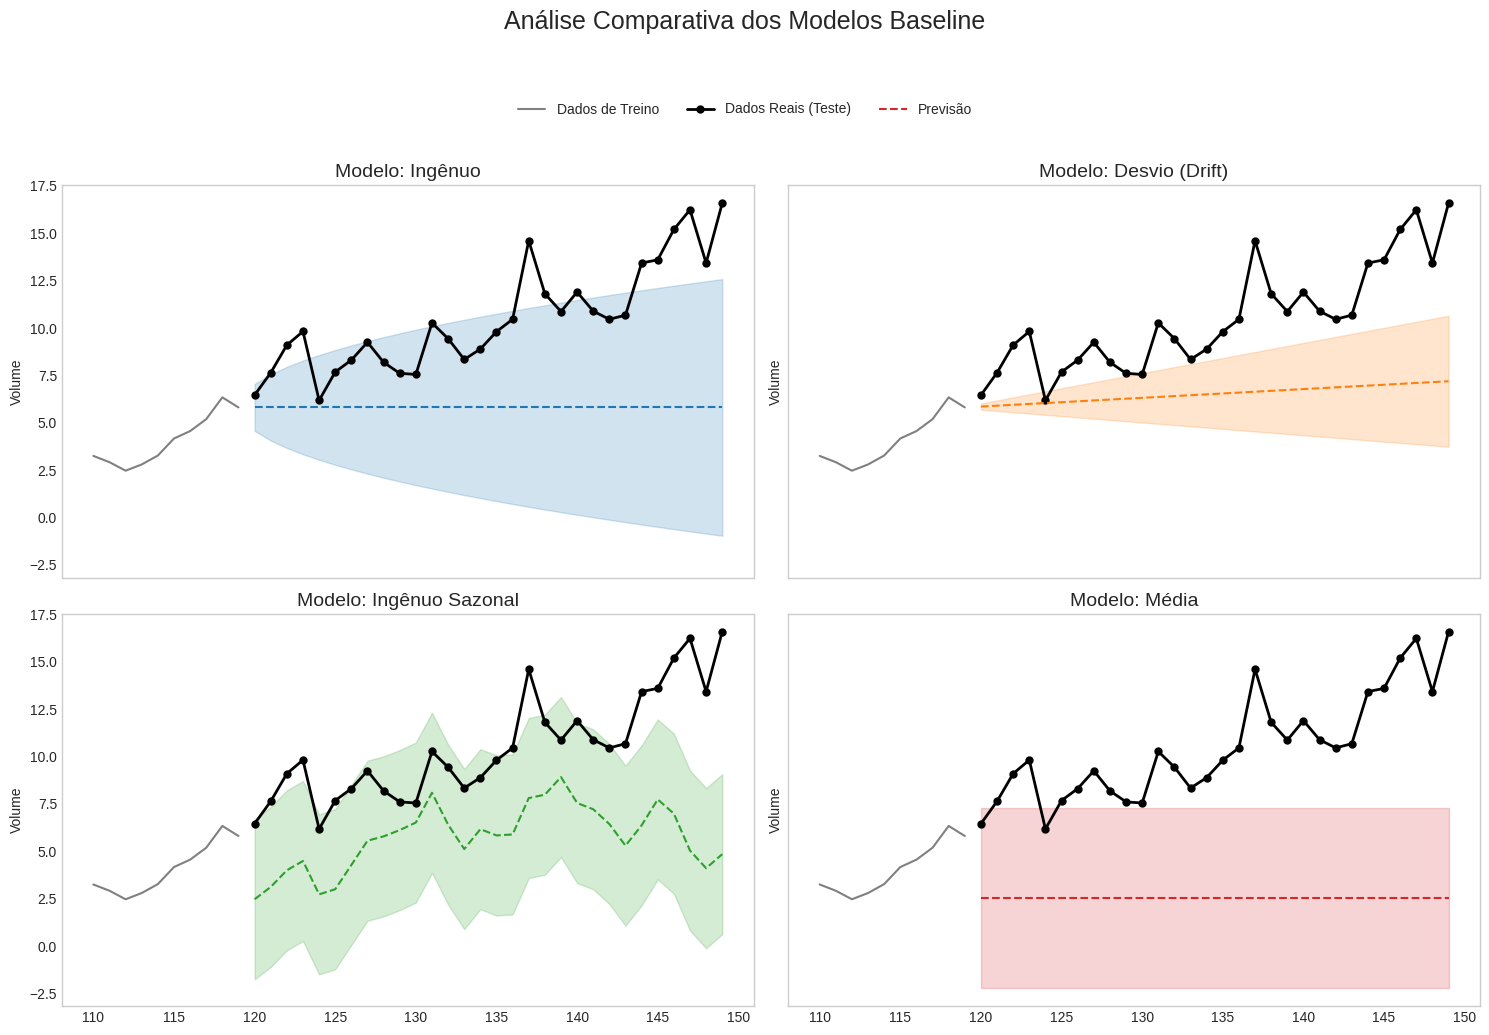

In [156]:
n_models = len(predictions)
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

# Define a paleta de cores
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] # Azul, Laranja, Verde, Vermelho

# << ALTERAÇÃO AQUI: Define a ordem de plotagem desejada
plot_order = ['Ingênuo', 'Desvio (Drift)', 'Ingênuo Sazonal', 'Média']

for i, name in enumerate(plot_order):
    ax = axes.flatten()[i] 
    color = colors[i % len(colors)]
    
    # Plota os dados base
    ax.plot(train.iloc[-10:], label='Dados de Treino', color='gray')
    ax.plot(test, label='Dados Reais (Teste)', color='black', linewidth=2, marker='o', markersize=5)
    
    # Previsão e intervalo com a cor específica
    forecast_to_plot = predictions[name]
    interval_to_plot = intervals[name]
    ax.plot(forecast_to_plot, label=f'Previsão', linestyle='--', color=color)
    
    # Plota o intervalo de previsão sombreado
    ax.fill_between(
        interval_to_plot['lower'].index,
        interval_to_plot['lower'],
        interval_to_plot['upper'],
        alpha=0.2,
        color=color
    )
    
    # Configurações do gráfico individual
    ax.set_title(f'Modelo: {name}', fontsize=14)
    ax.set_ylabel('Volume')
    ax.grid(False)

# Configurações gerais do painel de gráficos
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=4)
fig.suptitle('Análise Comparativa dos Modelos Baseline', fontsize=18, y=1.03)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

In [157]:
predictions_baseline = predictions.copy()

# Regressão Linear Múltipla com Covariáveis

Os modelos de Regressão Linear Múltipla foram desenvolvidos utilizando covariáveis baseadas nas variáveis `week` (Trend) e `volume` (Lags, Médias Móveis, Desvio Padrão Móvel). A estimação foi realizada via Mínimos Quadrados (OLS).

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

# Configurações para os gráficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

## Definindo as covariáveis

Iremos utilizar a covariável básica de trend, em conjunto com a indicadora mensal, e por fim, adicionar os lags de 1, 4 e 12 semanas, além disso, também iremos incluir as médias móveis e médias móveis exponencias de 4 e 12 semanas, e por fim, a volatilidade de 4 e 12 semanas.

Visto que a série temporal não apresenta sazonalidade anual, não iremos adicionar variáveis muito distantes no tempo.

In [159]:
# Carregando os dados originais
data = pd.read_csv("data.csv")
data["week"] = pd.to_datetime(data["week"])
data_series = data.set_index("week")['volume']

# --- Definição de Atributos ---
df = pd.DataFrame({'volume': data_series})
df['trend'] = range(len(df))

# Dummies mensais
df['month'] = df.index.month
df = pd.get_dummies(df, columns=['month'], drop_first=True, prefix='mes')
dummy_cols = [col for col in df.columns if 'mes_' in col]
df[dummy_cols] = df[dummy_cols].astype(int)

# Lags
df['lag_1'] = df['volume'].shift(1)
df['lag_4'] = df['volume'].shift(4)
df['lag_12'] = df['volume'].shift(12)

# Médias Móveis (Simples e Exponencial)
df['volume_sma_4'] = df['volume'].rolling(window=4).mean().shift(1)
df['volume_sma_12'] = df['volume'].rolling(window=12).mean().shift(1)
df['volume_ema_4'] = df['volume'].ewm(span=4, adjust=False).mean().shift(1)
df['volume_ema_12'] = df['volume'].ewm(span=12, adjust=False).mean().shift(1)

# Desvio Padrão Móvel
df['volume_std_4'] = df['volume'].rolling(window=4).std().shift(1)
df['volume_std_12'] = df['volume'].rolling(window=12).std().shift(1)

df.dropna(inplace=True)

X = df.drop('volume', axis=1)
y = df['volume']

As covariáveis criadas foram:
*   `trend`: Tendência linear.
*   *Dummies* mensais (`mes_x`).
*   *Lags*: $Lag_{1}, Lag_{4}, Lag_{12}$.
*   Médias Móveis (Simples e Exponenciais): $SMA_{4}, SMA_{12}, EMA_{4}, EMA_{12}$.
*   Volatilidade (Desvio Padrão Móvel): $StdDev_{4}, StdDev_{12}$.

Definindo o conjunto de treinamento e teste:

In [160]:
# Divisão cronológica dos dados
train_size_full = len(data_series)
train_size_adjusted = int(train_size_full * 0.8) - 12

X_train, X_test = X.iloc[:train_size_adjusted], X.iloc[train_size_adjusted:]
y_train, y_test = y.iloc[:train_size_adjusted], y.iloc[train_size_adjusted:]

train_volume = data_series.iloc[: int(train_size_full * 0.8)]
test_volume = data_series.iloc[int(train_size_full * 0.8) :]

## Gerando as predições dos modelos

Considerando as covariáveis como grupos, para ver o desempenho de cada grupo de variáveis.

In [161]:
predictions = {}
models = {}

months_cols = [col for col in X.columns if 'mes_' in col]
lag_cols = ['lag_1', 'lag_4', 'lag_12']
ma_cols = ['volume_sma_4', 'volume_sma_12', 'volume_ema_4', 'volume_ema_12']
std_cols = ['volume_std_4', 'volume_std_12']

models_cols = {
    'Tendência': ['trend'],
    'Meses': months_cols,
    'Lags': lag_cols,
    'Médias Móveis': ma_cols,
    'Desvio Padrão Móvel': std_cols,
}

for model_name, cols in models_cols.items():
    X_train_model = sm.add_constant(X_train[cols])
    X_test_model = sm.add_constant(X_test[cols])

    model = sm.OLS(y_train, X_train_model).fit()
    models[model_name] = model

    y_pred = model.predict(X_test_model)
    predictions[model_name] = y_pred

## Analisando as métricas das predições dos grupos

In [162]:
intervals = {}
residuals_std = {}


def update_and_get_metrics(
    models, predictions, results_list, train_volume, test_volume, alpha=0.05
):
    processed_models = [res['Modelo'] for res in results_list]

    new_model_names = [
        name for name in models.keys() if name not in processed_models
    ]

    if not new_model_names:
        return pd.DataFrame(results_list).set_index('Modelo')

    for name in new_model_names:
        residuals_std[name] = models[name].resid.std()

    for name in new_model_names:
        forecast = predictions[name]
        sigma = residuals_std[name]
        z_score = norm.ppf(1 - alpha / 2)
        intervals[name] = {
            'lower': forecast - z_score * sigma,
            'upper': forecast + z_score * sigma,
        }

    # --- Cálculo das Métricas ---
    m = 12  # Sazonalidade para o scale do MASE
    scale = np.mean(np.abs(train_volume.diff(m).dropna()))
    quantiles_to_check = [0.1, 0.25, 0.5, 0.75, 0.9]

    for name in new_model_names:
        forecast = predictions[name]
        current_test_volume = test_volume[forecast.index]
        interval = intervals[name]
        sigma = residuals_std[name]

        # Métricas de erro pontual
        mae = mean_absolute_error(current_test_volume, forecast)
        rmse = np.sqrt(mean_squared_error(current_test_volume, forecast))
        mape = mean_absolute_percentage_error(current_test_volume, forecast)
        mase = mae / scale

        # Métricas probabilísticas
        winkler = winkler_score(
            current_test_volume, interval['lower'], interval['upper'], alpha
        )
        sigma_h = pd.Series(sigma, index=current_test_volume.index)
        crps = crps_gaussian(current_test_volume, forecast, sigma_h)

        # Métrica de quantil
        avg_quantile_loss = []
        for p in quantiles_to_check:
            quantile_forecast = norm.ppf(p, loc=forecast, scale=sigma_h)
            avg_quantile_loss.append(
                quantile_score(current_test_volume, quantile_forecast, p)
            )

        # Adiciona os resultados à lista
        results_list.append(
            {
                'Modelo': name,
                'MAE': mae,
                'RMSE': rmse,
                'MAPE (%)': mape * 100,
                'MASE': mase,
                'Winkler Score': winkler,
                'Avg Quantile Score': np.mean(avg_quantile_loss),
                'CRPS': crps,
            }
        )

    return pd.DataFrame(results_list).set_index('Modelo')


results_list = []

results_df = update_and_get_metrics(
    models, predictions, results_list, train_volume, test_volume
)

print("\n--- Tabela Comparativa de Métricas (Grupos de Covariáveis) ---")
results_df.round(4).sort_values(by='RMSE')


--- Tabela Comparativa de Métricas (Grupos de Covariáveis) ---


,MAE,RMSE,MAPE (%),MASE,Winkler Score,Avg Quantile Score,CRPS
Modelo,,,,,,,
Médias Móveis,1.3680,1.7275,13.1918,1.0057,19.9436,0.5458,1.0940
Lags,1.3731,1.7571,12.9775,1.0095,22.2627,0.5457,1.0980
Desvio Padrão Móvel,3.7363,4.4954,33.7427,2.7467,78.0712,1.5835,3.1663
Tendência,3.8318,4.5048,33.2286,2.8169,53.7312,1.5146,3.0359
Meses,7.2768,7.7198,68.1374,5.3495,120.3251,3.0051,5.9801


Pelos resultados podemos observar que o modelo de médias móveis apresentou o melhor desempenho, seguido do modelo com lags, que performaram bem melhores do que o modelo básico com trend e volatiliade, e o modelo de indicadoras mensais foi o pior de todos.

## Analisando os parâmetros dos melhores modelos

In [163]:
models["Médias Móveis"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 volume   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     328.9
Date:                Sun, 05 Oct 2025   Prob (F-statistic):           1.07e-57
Time:                        14:21:31   Log-Likelihood:                -107.90
No. Observations:                 108   AIC:                             225.8
Df Residuals:                     103   BIC:                             239.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1341      0.102      1.316      0.191      -0.068       0.336
volume_sma_4     -1.3314      0.364     -3.660      0.000      -2.053      -0.610
volume_sma_12    -0.7518      0.430     -1.747      0.084      -1.605       0.102
volume_ema_4      2.6379      0.386      6.838      0.000       1.873       3.403
volume_ema_12     0.4198      0.540      0.777      0.439      -0.651       1.491
==============================================================================
Omnibus:                        7.729   Durbin-Watson:                   1.579
Prob(Omnibus):                  0.021   Jarque-Bera (JB):               14.378
Skew:                          -0.130   Prob(JB):                     0.000755
Kurtosis:                       4.769   Cond. No.                         75.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [164]:
models["Lags"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 volume   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     510.7
Date:                Sun, 05 Oct 2025   Prob (F-statistic):           4.63e-62
Time:                        14:21:31   Log-Likelihood:                -100.72
No. Observations:                 108   AIC:                             209.4
Df Residuals:                     104   BIC:                             220.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1568      0.091      1.717      0.089      -0.024       0.338
lag_1          0.8982      0.057     15.719      0.000       0.785       1.011
lag_4          0.1660      0.072      2.321      0.022       0.024       0.308
lag_12        -0.1091      0.044     -2.505      0.014      -0.195      -0.023
==============================================================================
Omnibus:                        5.943   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                9.322
Skew:                          -0.079   Prob(JB):                      0.00946
Kurtosis:                       4.431   Cond. No.                         9.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Vemos um problema no modelo de médias móveis, onde o parâmetro volume_ema_12 tem um p-valor alto, e seu intervalo de confiança inclui o zero, indicando que esse parâmetro não é estatisticamente significativo.

Levando isso em consideração, criaremos novos modelos removendo esse parâmetro e juntando mais grupos de variáveis para analisar o desempenho.

In [165]:
ma_cols.remove("volume_ema_12")

models_combined_cols = {
    "Lags + Médias Móveis": lag_cols + ma_cols,
    "Lags + Médias Móveis + Tendência": lag_cols + ma_cols + ['trend'],
    "Lags + Médias Móveis + Desvio Padrão": lag_cols + ma_cols + std_cols,
}

for model_name, cols in models_combined_cols.items():
    X_train_model = sm.add_constant(X_train[cols])
    X_test_model = sm.add_constant(X_test[cols])

    model = sm.OLS(y_train, X_train_model).fit()
    models[model_name] = model

    y_pred = model.predict(X_test_model)
    predictions[model_name] = y_pred

In [166]:
results_df = update_and_get_metrics(models, predictions, results_list, train_volume, test_volume)

print("\n--- Tabela Comparativa de Métricas Atualizada (Modelos Combinados) ---")
results_df.round(4).sort_values(by='RMSE')


--- Tabela Comparativa de Métricas Atualizada (Modelos Combinados) ---


,MAE,RMSE,MAPE (%),MASE,Winkler Score,Avg Quantile Score,CRPS
Modelo,,,,,,,
Médias Móveis,1.3680,1.7275,13.1918,1.0057,19.9436,0.5458,1.0940
Lags,1.3731,1.7571,12.9775,1.0095,22.2627,0.5457,1.0980
Lags + Médias Móveis,1.4475,1.8576,13.8147,1.0642,25.0619,0.5993,1.1969
Lags + Médias Móveis + Tendência,1.4439,1.8770,13.6818,1.0615,25.7232,0.5964,1.1915
Lags + Médias Móveis + Desvio Padrão,1.5293,2.0021,14.4195,1.1243,28.6114,0.6384,1.2755
Desvio Padrão Móvel,3.7363,4.4954,33.7427,2.7467,78.0712,1.5835,3.1663
Tendência,3.8318,4.5048,33.2286,2.8169,53.7312,1.5146,3.0359
Meses,7.2768,7.7198,68.1374,5.3495,120.3251,3.0051,5.9801


Analisando os grupos de modelos é visível que, apenas o grupo de lags com médias móveis já apresenta o melhor desempenho, não sendo necessário adicionar a tendência e a volatilidade, que não melhoraram o desempenho do modelo.

In [167]:
models["Lags + Médias Móveis"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 volume   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     261.2
Date:                Sun, 05 Oct 2025   Prob (F-statistic):           3.75e-59
Time:                        14:21:31   Log-Likelihood:                -98.096
No. Observations:                 108   AIC:                             210.2
Df Residuals:                     101   BIC:                             229.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1676      0.091      1.849      0.067      -0.012       0.347
lag_1             1.0173      0.364      2.797      0.006       0.296       1.739
lag_4             0.2702      0.187      1.445      0.152      -0.101       0.641
lag_12           -0.2554      0.098     -2.596      0.011      -0.451      -0.060
volume_sma_4     -0.5042      0.982     -0.513      0.609      -2.453       1.444
volume_sma_12     0.3807      0.345      1.105      0.272      -0.303       1.064
volume_ema_4      0.0440      1.401      0.031      0.975      -2.735       2.823
==============================================================================
Omnibus:                        4.956   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                7.002
Skew:                           0.005   Prob(JB):                       0.0302
Kurtosis:                       4.247   Cond. No.                         248.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Pelos seus resultados, podemos ver que o parâmetro lag_12 não é estatisticamente significativo, então iremos criar um novo modelo sem esse parâmetro.

In [168]:
lag_cols.remove("lag_12")
models["Modelo Final"] = sm.OLS(
    y_train, sm.add_constant(X_train[lag_cols + ma_cols])
).fit()
predictions["Modelo Final"] = models["Modelo Final"].predict(
    sm.add_constant(X_test[lag_cols + ma_cols])
)

models["Modelo Final"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 volume   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     295.4
Date:                Sun, 05 Oct 2025   Prob (F-statistic):           5.35e-59
Time:                        14:21:31   Log-Likelihood:                -101.58
No. Observations:                 108   AIC:                             215.2
Df Residuals:                     102   BIC:                             231.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1441      0.093      1.555      0.123      -0.040       0.328
lag_1             0.6973      0.352      1.983      0.050      -0.000       1.395
lag_4             0.4038      0.185      2.185      0.031       0.037       0.770
volume_sma_4     -1.3097      0.958     -1.368      0.174      -3.209       0.590
volume_sma_12    -0.3387      0.210     -1.610      0.110      -0.756       0.079
volume_ema_4      1.5107      1.317      1.147      0.254      -1.102       4.124
==============================================================================
Omnibus:                        6.258   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.044   Jarque-Bera (JB):               10.405
Skew:                           0.037   Prob(JB):                      0.00550
Kurtosis:                       4.519   Cond. No.                         212.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [169]:
results_df = update_and_get_metrics(
    models, predictions, results_list, train_volume, test_volume
)

print("\n--- Tabela Comparativa Final de Métricas ---")
results_df.round(4).sort_values(by='RMSE')


--- Tabela Comparativa Final de Métricas ---


,MAE,RMSE,MAPE (%),MASE,Winkler Score,Avg Quantile Score,CRPS
Modelo,,,,,,,
Médias Móveis,1.3680,1.7275,13.1918,1.0057,19.9436,0.5458,1.0940
Lags,1.3731,1.7571,12.9775,1.0095,22.2627,0.5457,1.0980
Modelo Final,1.4140,1.7741,13.4372,1.0395,22.8986,0.5651,1.1346
Lags + Médias Móveis,1.4475,1.8576,13.8147,1.0642,25.0619,0.5993,1.1969
Lags + Médias Móveis + Tendência,1.4439,1.8770,13.6818,1.0615,25.7232,0.5964,1.1915
Lags + Médias Móveis + Desvio Padrão,1.5293,2.0021,14.4195,1.1243,28.6114,0.6384,1.2755
Desvio Padrão Móvel,3.7363,4.4954,33.7427,2.7467,78.0712,1.5835,3.1663
Tendência,3.8318,4.5048,33.2286,2.8169,53.7312,1.5146,3.0359
Meses,7.2768,7.7198,68.1374,5.3495,120.3251,3.0051,5.9801


Resultou em um modelo quase infimamente pior, mas com parâmetros significativos.

## Visualizando resultados

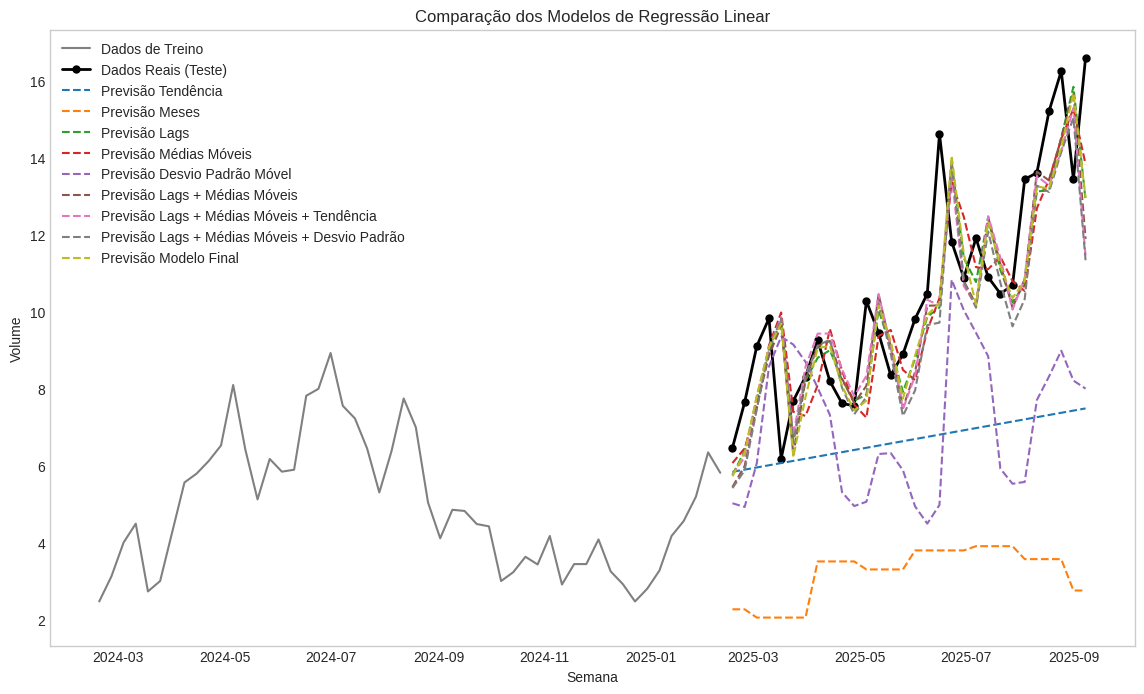

In [170]:
# Visualização e Avaliação Final

plt.figure(figsize=(14, 8))
plt.plot(y_train.iloc[-52:], label='Dados de Treino', color='gray')

predictions_rm = {}

plt.plot(
    y_test,
    label='Dados Reais (Teste)',
    color='black',
    linewidth=2,
    marker='o',
    markersize=5,
)

for name, forecast in predictions.items():
    plt.plot(forecast, label=f'Previsão {name}', linestyle='--')
    predictions_rm[name] = predictions[name]

plt.title('Comparação dos Modelos de Regressão Linear')
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.legend(loc='upper left')
plt.grid(False)

plt.show()

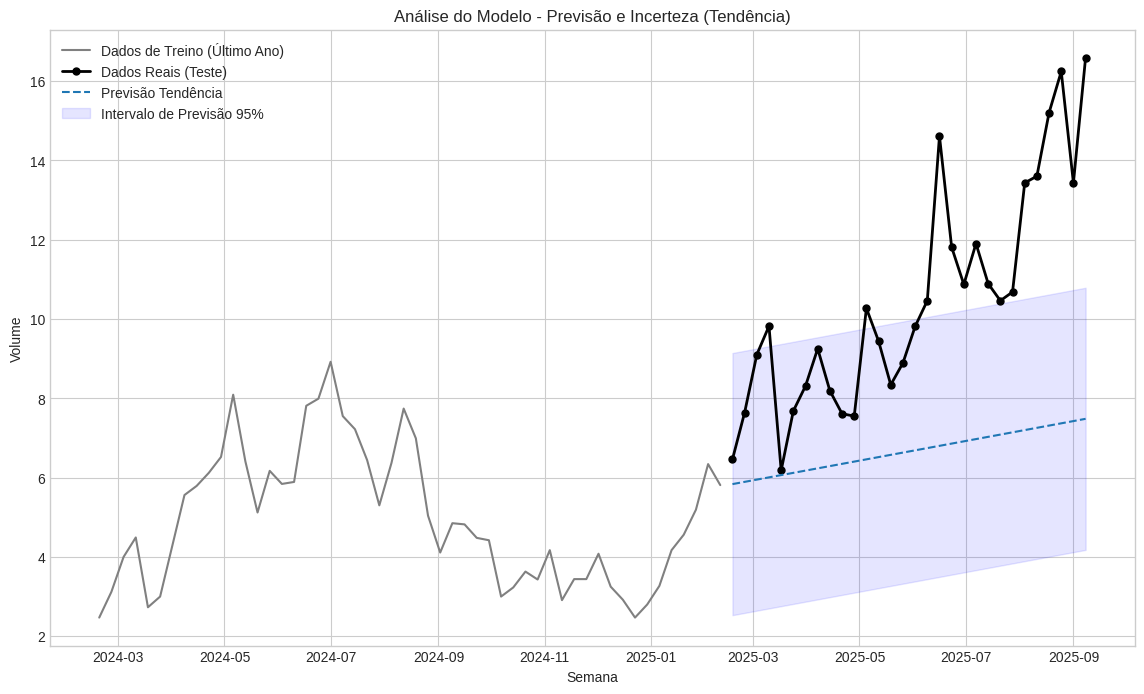

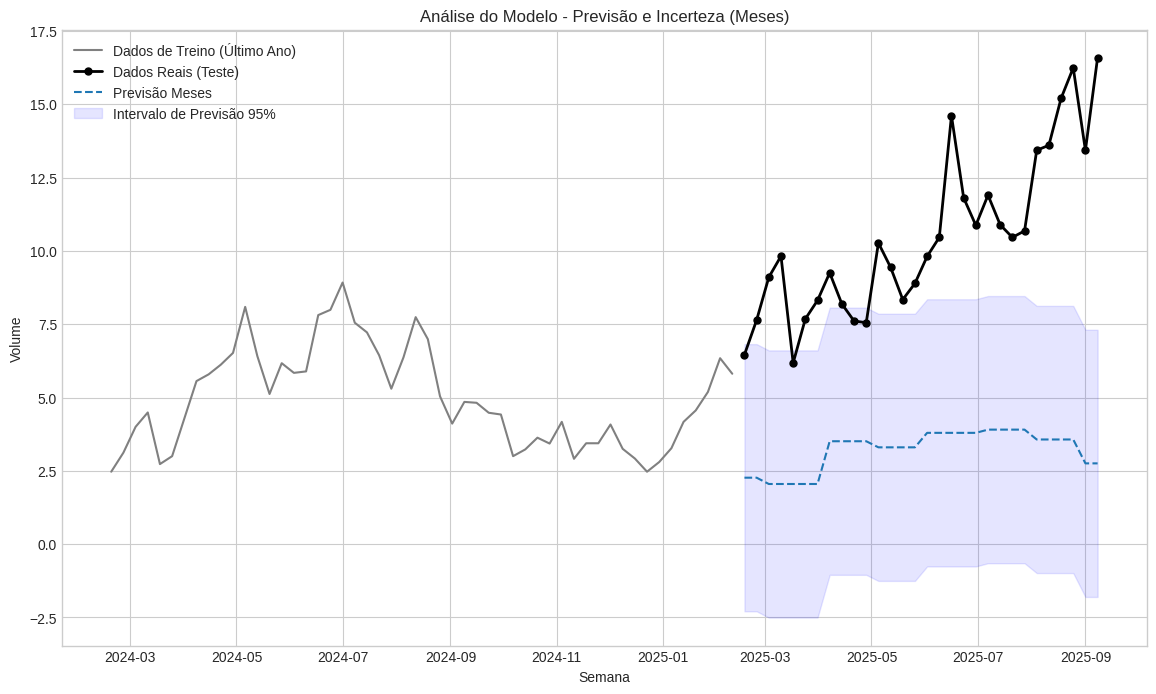

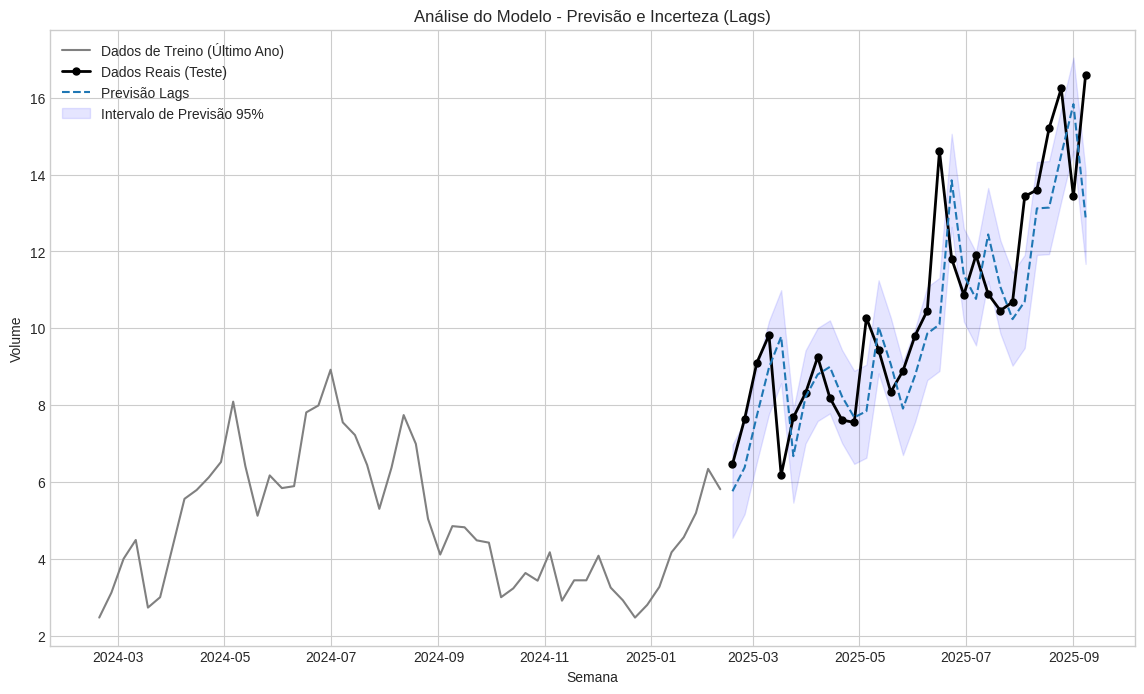

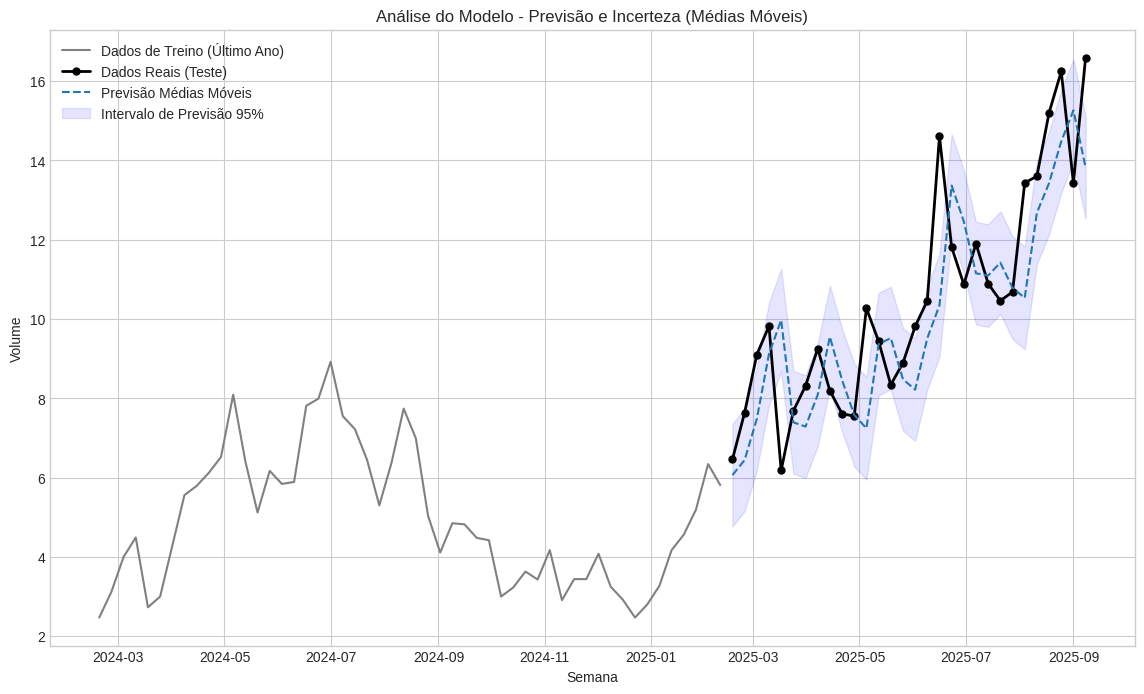

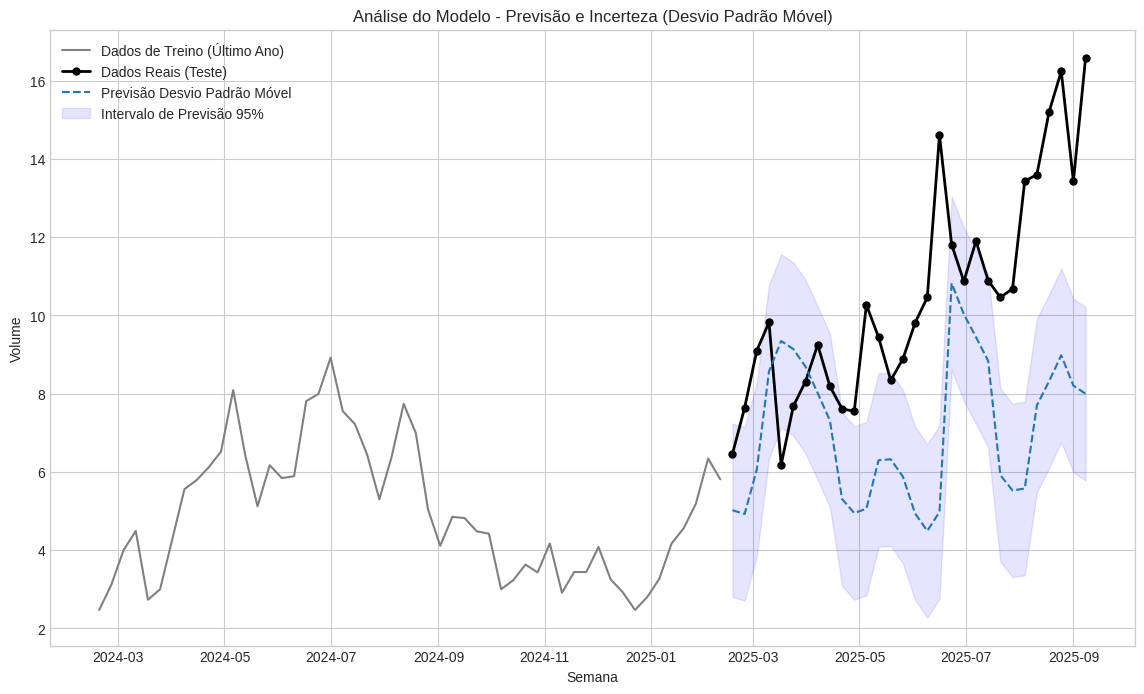

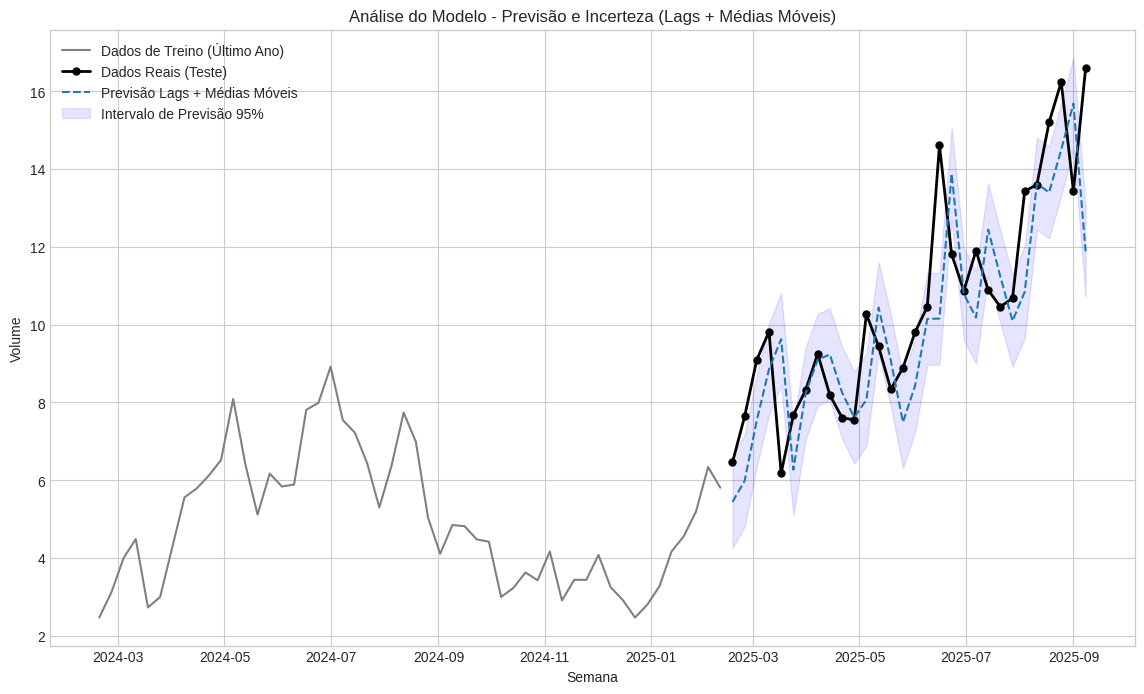

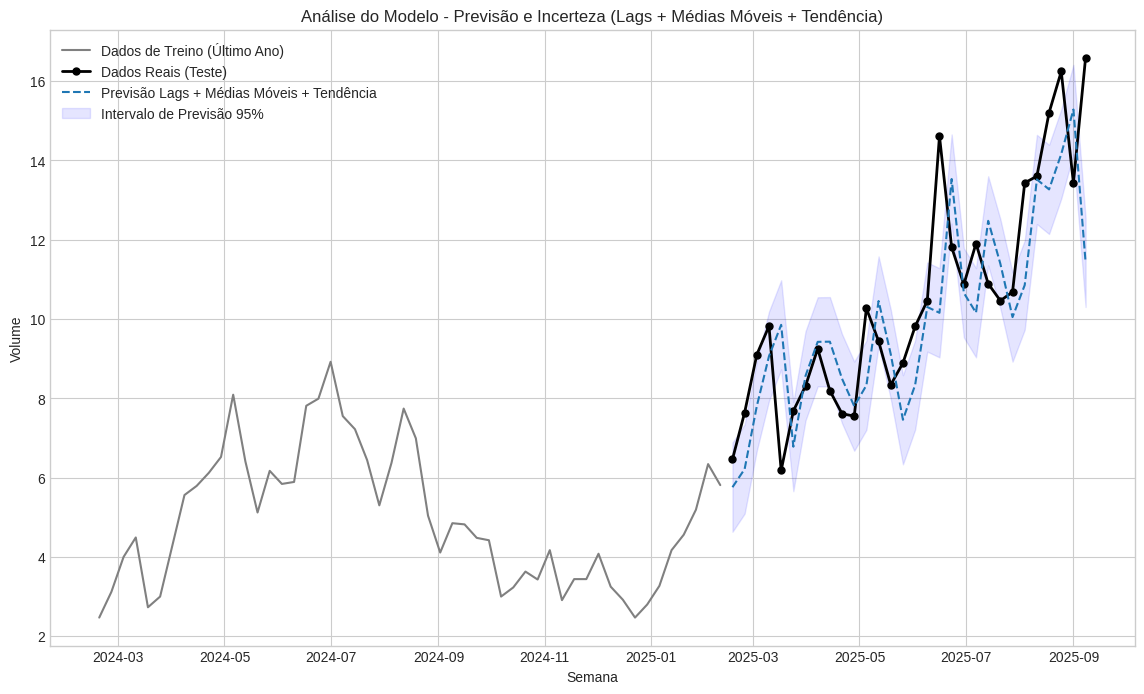

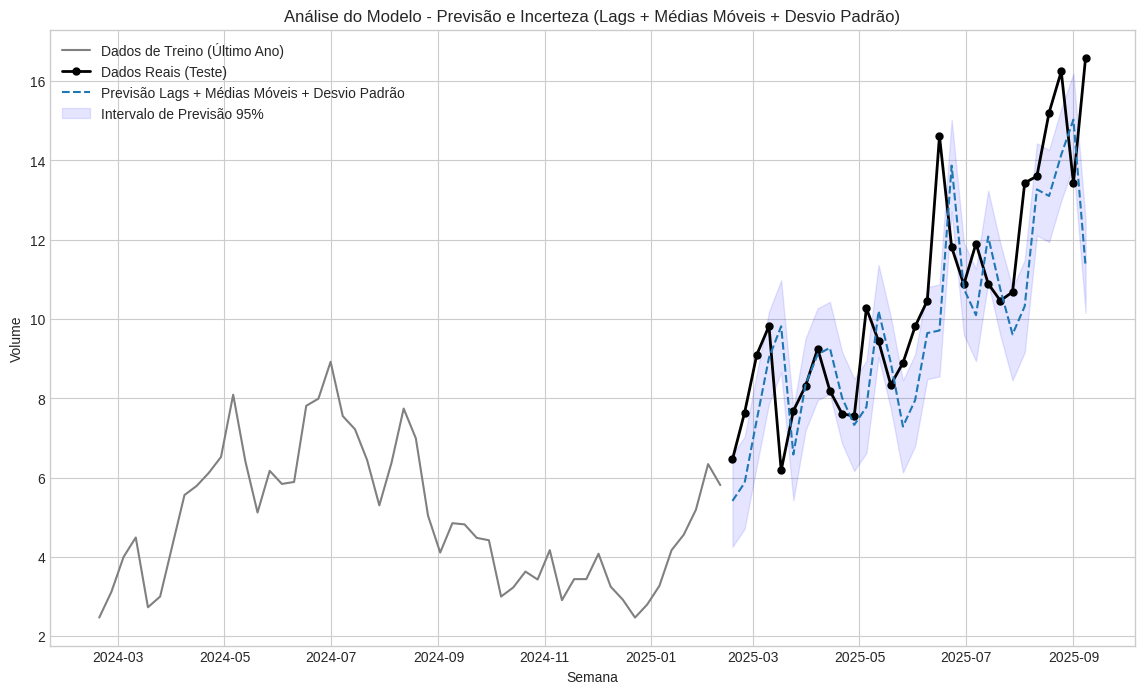

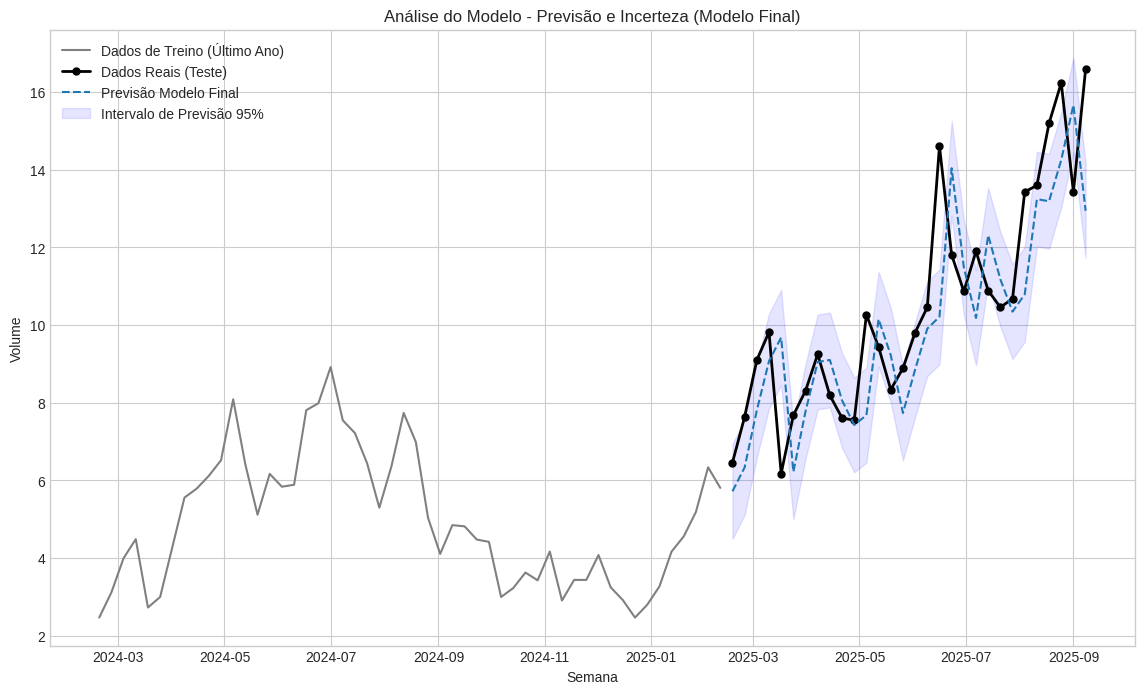

In [171]:
model_names = models.keys()

for name in model_names:
    plt.figure(figsize=(14, 8))

    plt.plot(
        y_train.iloc[-52:], label='Dados de Treino (Último Ano)', color='gray'
    )
    plt.plot(
        y_test,
        label='Dados Reais (Teste)',
        color='black',
        linewidth=2,
        marker='o',
        markersize=5,
    )

    forecast_to_plot = predictions[name]
    interval_to_plot = intervals[name]

    plt.plot(forecast_to_plot, label=f'Previsão {name}', linestyle='--')

    plt.fill_between(
        interval_to_plot['lower'].index,
        interval_to_plot['lower'],
        interval_to_plot['upper'],
        color='blue',
        alpha=0.1,
        label='Intervalo de Previsão 95%',
    )

    plt.title(f'Análise do Modelo - Previsão e Incerteza ({name})')
    plt.xlabel('Semana')
    plt.ylabel('Volume')
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.show()

Por fim, visualizamos os resultados do modelo final, que apresentou um desempenho muito bom, todos os parâmetros estatisticamente significativos. Além disso, o modelo conseguiu capturar a maioria dos padrões da série temporal.

# Resíduos e Ajuste dos Modelos

In [172]:
ts_volume = data['volume']

percent_data = int((len(ts_volume)*0.2 ))
# Divisão cronológica dos dados
train = ts_volume.iloc[:-percent_data]
test = ts_volume.iloc[-percent_data:]

## Baselines

In [173]:
residuals = {}
for key, value in predictions_baseline.items():
    residuals[key] = test - value


----------------------------------------
Métricas de Erro - Média
----------------------------------------
MAE: 7.9639
RMSE: 8.4335
MAPE: 74.25%

----------------------------------------
Análise dos resíduos - Média
----------------------------------------

Média Dados: 10.4903
Média: 7.9639


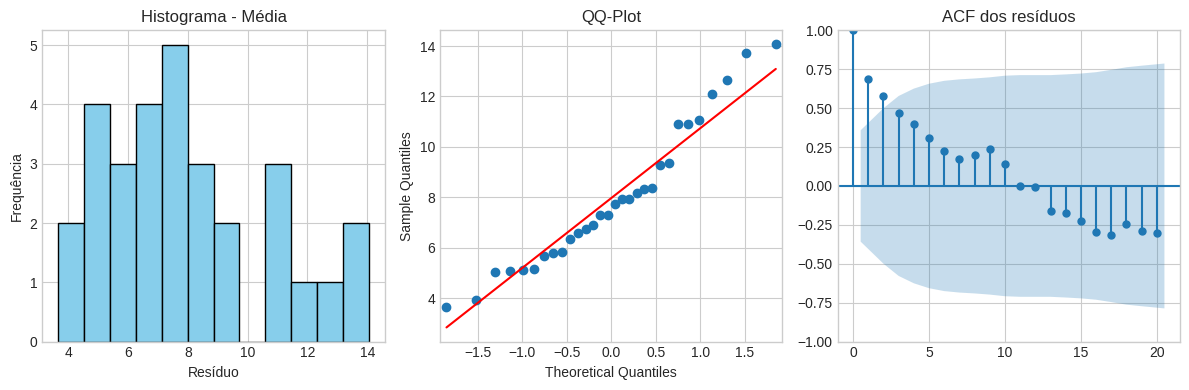


----------------------------------------
Métricas de Erro - Ingênuo
----------------------------------------
MAE: 4.6803
RMSE: 5.4411
MAPE: 40.79%

----------------------------------------
Análise dos resíduos - Ingênuo
----------------------------------------

Média Dados: 10.4903
Média: 4.6803


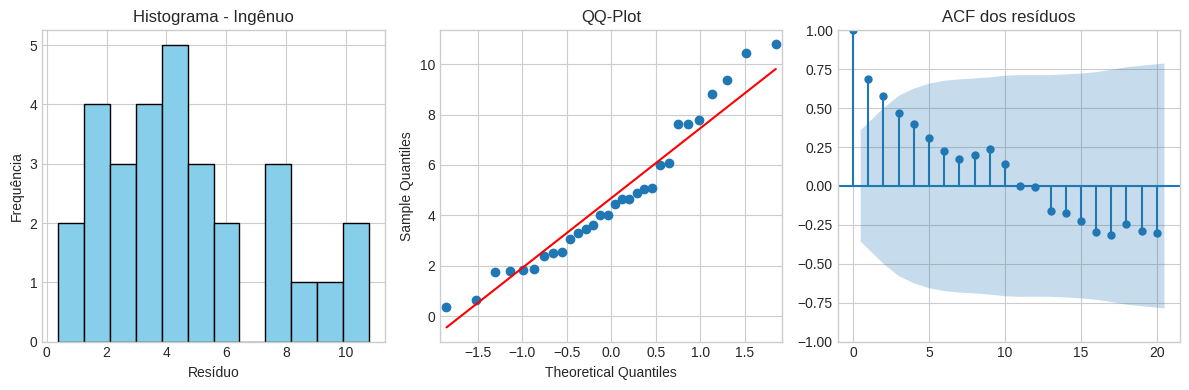


----------------------------------------
Métricas de Erro - Desvio (Drift)
----------------------------------------
MAE: 3.9666
RMSE: 4.6585
MAPE: 34.40%

----------------------------------------
Análise dos resíduos - Desvio (Drift)
----------------------------------------

Média Dados: 10.4903
Média: 3.9666


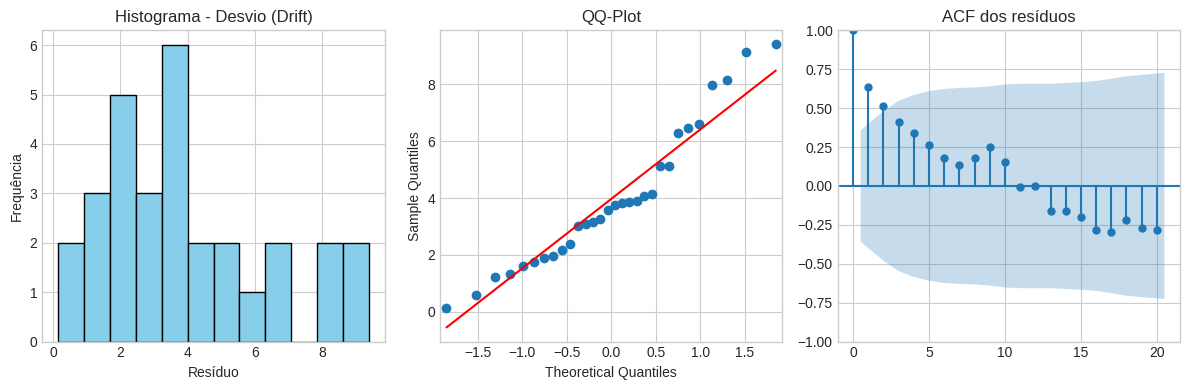


----------------------------------------
Métricas de Erro - Ingênuo Sazonal
----------------------------------------
MAE: 4.7593
RMSE: 5.4027
MAPE: 44.01%

----------------------------------------
Análise dos resíduos - Ingênuo Sazonal
----------------------------------------

Média Dados: 10.4903
Média: 4.7593


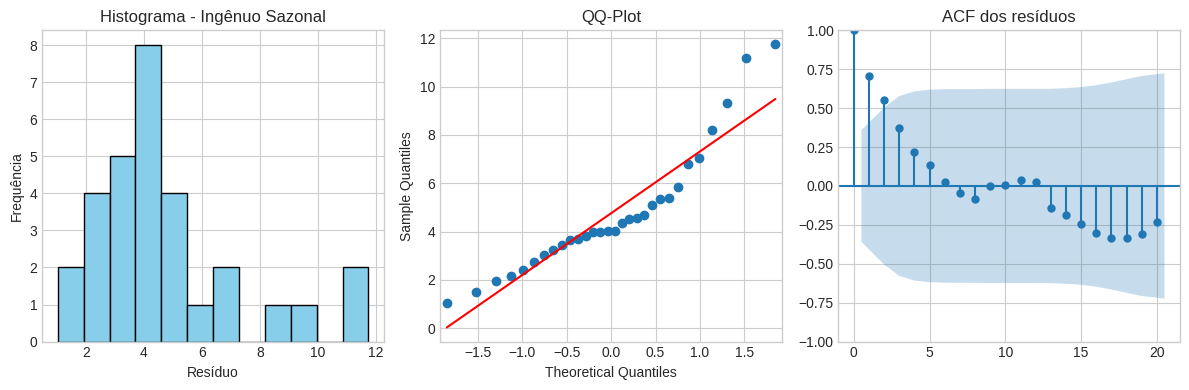

In [174]:
for key, res in residuals.items():

    mae = np.mean(np.abs(res))
    rmse = np.sqrt(np.mean(res**2))
    mape = np.mean(np.abs(res / test)) * 100  # percentual

    print(f"\n{'-'*40}\nMétricas de Erro - {key}\n{'-'*40}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")

    print(f"\n{'-'*40}\nAnálise dos resíduos - {key}\n{'-'*40}\n")
    
    # Média
    mean_res = np.mean(res)
    print(f"Média Dados: {np.mean(test):.4f}")
    print(f"Média: {mean_res:.4f}")
    
    # Histograma
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.hist(res, bins=12, color='skyblue', edgecolor='black')
    plt.title(f"Histograma - {key}")
    plt.xlabel("Resíduo")
    plt.ylabel("Frequência")

    # QQ - Plot
    plt.subplot(1, 3, 2)
    sm.qqplot(res, line='s', ax=plt.gca())
    plt.title("QQ-Plot")

    # ACF
    plt.subplot(1, 3, 3)
    plot_acf(res, ax=plt.gca(), lags=20)
    plt.title("ACF dos resíduos")

    plt.tight_layout()
    plt.show()

## Análise dos Resultados

### Métricas de Erro

- **Mean Absolute Error (MAE)**: Com exceção do Modelo Média, os outros três modelos apresentam MAE semelhantes, em torno de 4, indicando que erram aproximadamente 40% da média dos dados. O destaque negativo é o Modelo Média, que apresentou MAE próximo de 8.

- **Root Mean Squared Error (RMSE)**: Mais uma vez, os três últimos modelos apresentam resultados semelhantes, enquanto o Modelo Média se destaca negativamente. Isso tem uma explicação: o RMSE penaliza mais fortemente erros grandes, indicando que o modelo lida mal com valores que fogem do padrão. Isso é esperado, já que o Modelo Média é literalmente uma linha horizontal.

- **Mean Absolute Percentage Error (MAPE)**: Os três últimos modelos novamente apresentam resultados próximos, em torno de 35%. O Modelo Média teve MAPE de 75%, confirmando, mais uma vez, o ajuste ruim do modelo.


### Média dos Resíduos

- **Média**: 7.9639
- **Ingênuo**: 4.6803
- **Desvio (Drift)**: 3.9666
- **Ingênuo Sazonal**: 4.7593

Analisando a média dos resíduos dos quatro modelos baseline, é possível inferir que o ajuste não foi adequado. O esperado é que os resíduos apresentem média próxima de zero ou, em algumas referências, até 5% da média dos dados. Claramente, isso não aconteceu, uma vez que a média dos dados é 10.4903, e a menor média dos resíduos representa 37% da média dos dados. 

### Histograma

Foram utilizados 30 pontos de dados para a análise do ajuste. Esse número é relativamente pequeno, tornando o histograma um pouco impreciso e incapaz de fornecer um veredito definitivo. No entanto, analisando os histogramas de todos os modelos, observa-se que eles não seguem uma distribuição normal, principalmente devido à assimetria, com maior concentração de valores à esquerda.

### QQ-Plot

O aspecto importante a ser observado aqui é se os pontos seguem a diagonal. Em todos os modelos, nota-se que os pontos estão consistentemente acima ou abaixo da diagonal, especialmente nas extremidades. Isso indica que as caudas estão mais pesadas do que deveriam se a distribuição fosse normal.

### ACF

Os resultados são bastante semelhantes entre todos os modelos. Observa-se autocorrelação positiva nos primeiros lags, seguida de uma queda nos valores subsequentes. Isso indica que há dependência temporal nos resíduos que os modelos não capturaram, sugerindo que os modelos estão subajustados e não modelaram toda a correlação da série.

## Regressão Múltipla

In [177]:
residuals_rm = {}
for key, value in predictions_rm.items():
    residuals_rm[key] = test.values - value.values


----------------------------------------
Métricas de Erro - Tendência
----------------------------------------
MAE: 3.8318
RMSE: 4.5048
MAPE: 33.23%

----------------------------------------
Análise dos resíduos - Tendência
----------------------------------------

Média Dados: 10.4903
Média: 3.8318


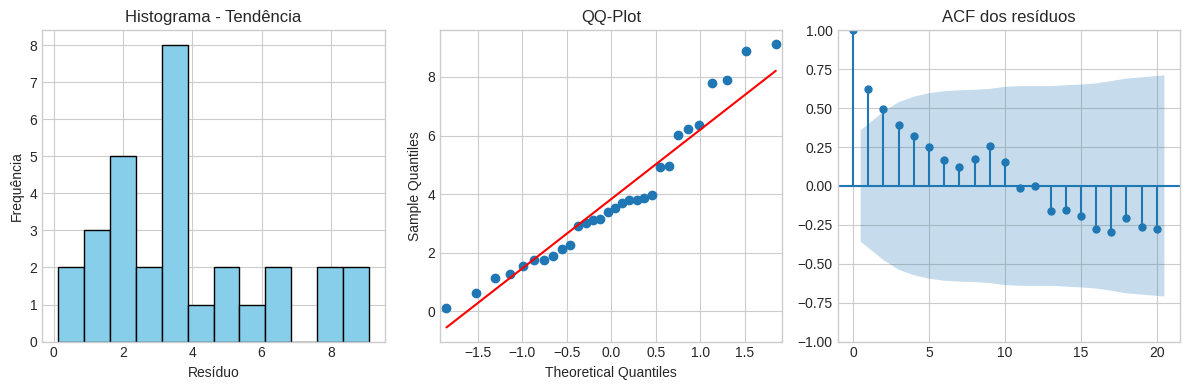


----------------------------------------
Métricas de Erro - Meses
----------------------------------------
MAE: 7.2768
RMSE: 7.7198
MAPE: 68.14%

----------------------------------------
Análise dos resíduos - Meses
----------------------------------------

Média Dados: 10.4903
Média: 7.2768


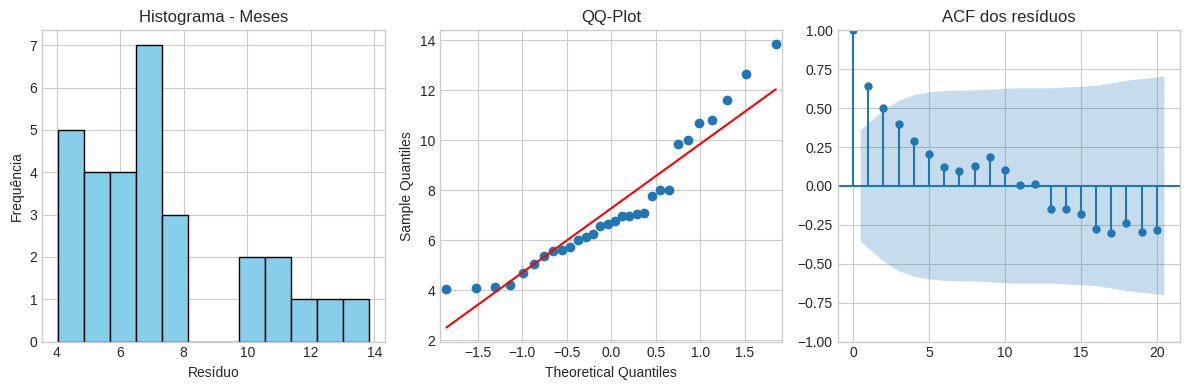


----------------------------------------
Métricas de Erro - Lags
----------------------------------------
MAE: 1.3731
RMSE: 1.7571
MAPE: 12.98%

----------------------------------------
Análise dos resíduos - Lags
----------------------------------------

Média Dados: 10.4903
Média: 0.4672


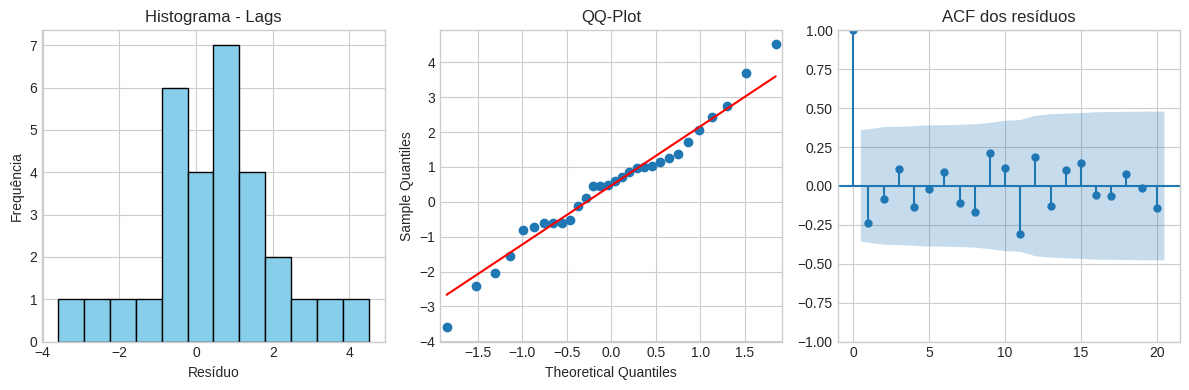


----------------------------------------
Métricas de Erro - Médias Móveis
----------------------------------------
MAE: 1.3680
RMSE: 1.7275
MAPE: 13.19%

----------------------------------------
Análise dos resíduos - Médias Móveis
----------------------------------------

Média Dados: 10.4903
Média: 0.4716


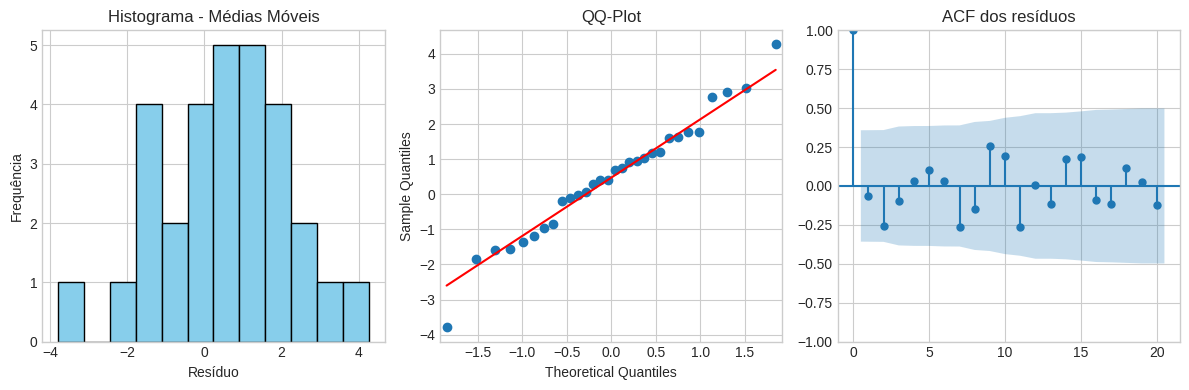


----------------------------------------
Métricas de Erro - Desvio Padrão Móvel
----------------------------------------
MAE: 3.7363
RMSE: 4.4954
MAPE: 33.74%

----------------------------------------
Análise dos resíduos - Desvio Padrão Móvel
----------------------------------------

Média Dados: 10.4903
Média: 3.4027


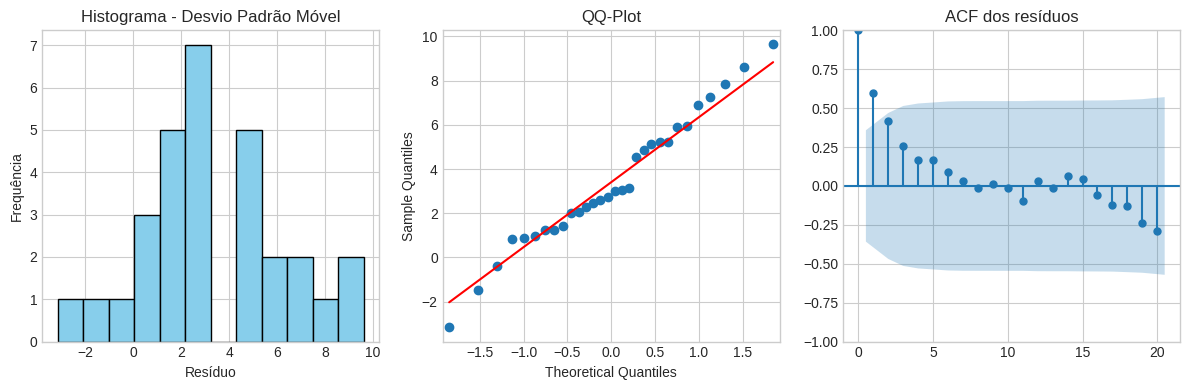


----------------------------------------
Métricas de Erro - Lags + Médias Móveis
----------------------------------------
MAE: 1.4475
RMSE: 1.8576
MAPE: 13.81%

----------------------------------------
Análise dos resíduos - Lags + Médias Móveis
----------------------------------------

Média Dados: 10.4903
Média: 0.5391


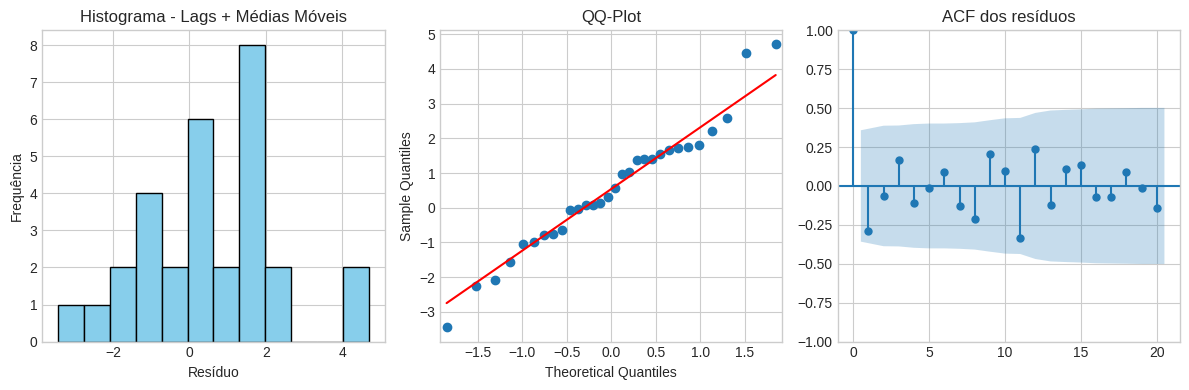


----------------------------------------
Métricas de Erro - Lags + Médias Móveis + Tendência
----------------------------------------
MAE: 1.4439
RMSE: 1.8770
MAPE: 13.68%

----------------------------------------
Análise dos resíduos - Lags + Médias Móveis + Tendência
----------------------------------------

Média Dados: 10.4903
Média: 0.4882


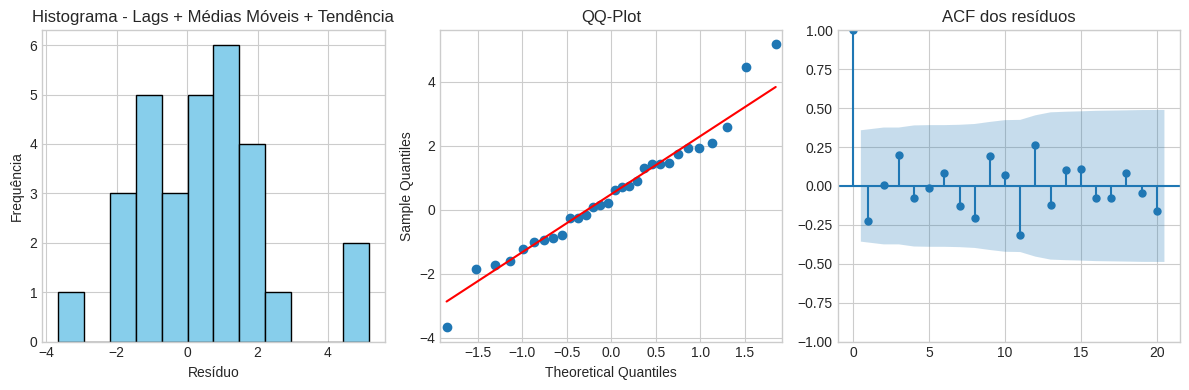


----------------------------------------
Métricas de Erro - Lags + Médias Móveis + Desvio Padrão
----------------------------------------
MAE: 1.5293
RMSE: 2.0021
MAPE: 14.42%

----------------------------------------
Análise dos resíduos - Lags + Médias Móveis + Desvio Padrão
----------------------------------------

Média Dados: 10.4903
Média: 0.7558


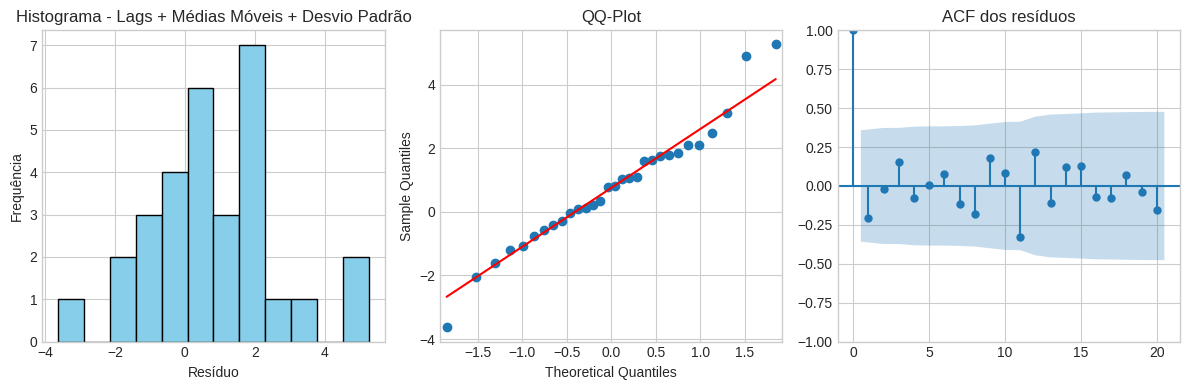


----------------------------------------
Métricas de Erro - Modelo Final
----------------------------------------
MAE: 1.4140
RMSE: 1.7741
MAPE: 13.44%

----------------------------------------
Análise dos resíduos - Modelo Final
----------------------------------------

Média Dados: 10.4903
Média: 0.5004


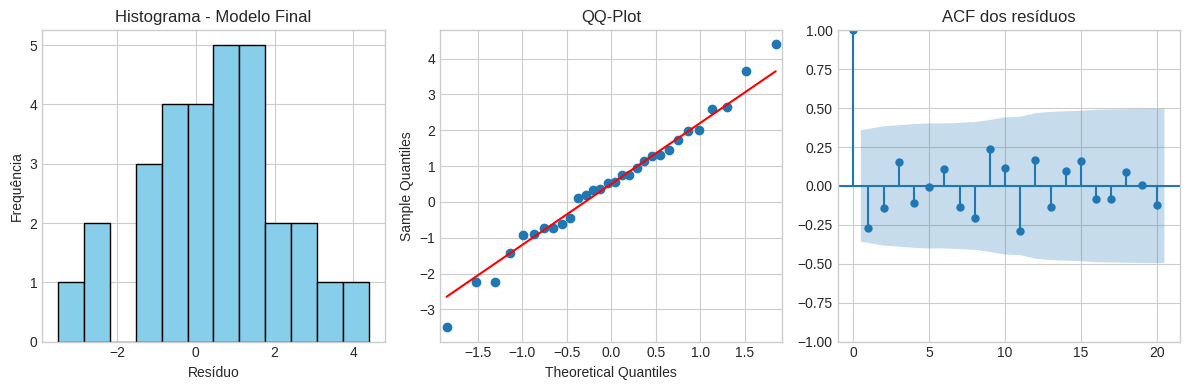

In [178]:
for key, res in residuals_rm.items():

    mae = np.mean(np.abs(res))
    rmse = np.sqrt(np.mean(res**2))
    mape = np.mean(np.abs(res / test)) * 100  # percentual

    print(f"\n{'-'*40}\nMétricas de Erro - {key}\n{'-'*40}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")

    print(f"\n{'-'*40}\nAnálise dos resíduos - {key}\n{'-'*40}\n")
    
    # Média
    mean_res = np.mean(res)
    print(f"Média Dados: {np.mean(test):.4f}")
    print(f"Média: {mean_res:.4f}")
    
    # Histograma
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.hist(res, bins=12, color='skyblue', edgecolor='black')
    plt.title(f"Histograma - {key}")
    plt.xlabel("Resíduo")
    plt.ylabel("Frequência")

    # QQ - Plot
    plt.subplot(1, 3, 2)
    sm.qqplot(res, line='s', ax=plt.gca())
    plt.title("QQ-Plot")

    # ACF
    plt.subplot(1, 3, 3)
    plot_acf(res, ax=plt.gca(), lags=20)
    plt.title("ACF dos resíduos")

    plt.tight_layout()
    plt.show()

## Análise dos Resultados

### Métricas de Erro

- **Mean Absolute Error (MAE)**: 
  
  - Tendência: 3.8318
  - Meses: 7.2768
  - Lags: 1.3731
  - Médias Móveis: 1.3680
  - Desvio Padrão Móvel: 3.7363
  - Lags + Médias Móveis: 1.4475
  - Lags + Médias Móveis + Tendência: 1.4439
  - Lags + Médias Móveis + Desvio Padrão: 1.5293
  - Modelo Final: 1.4140

- **Root Mean Squared Error (RMSE)**: 

  - Tendência: 4.5048
  - Meses: 7.7198
  - Lags: 1.7571
  - Médias Móveis: 1.7275
  - Desvio Padrão Móvel: 4.4954
  - Lags + Médias Móveis: 1.8576
  - Lags + Médias Móveis + Tendência: 1.8770
  - Lags + Médias Móveis + Desvio Padrão: 2.0021
  - Modelo Final: 1.7741

- **Mean Absolute Percentage Error (MAPE)**: 

  - Tendência: 33.23%
  - Meses: 68.14%
  - Lags: 12.98%
  - Médias Móveis: 13.19%
  - Desvio Padrão Móvel: 33.74%
  - Lags + Médias Móveis: 13.81%
  - Lags + Médias Móveis + Tendência: 13.68%
  - Lags + Médias Móveis + Desvio Padrão: 14.42%
  - Modelo Final: 13.44%

**Análise geral:**  
Como são muitos modelos, analisarei de forma geral. No **MAE**, muitos modelos apresentam desempenho parecido, mas há três destaques negativos: Tendência, Desvio Padrão Móvel e, o pior de todos, Meses. O restante apresenta desempenho similar. No **RMSE**, o cenário se repete, com a maioria próxima e os mesmos três destoando, novamente com Meses sendo o pior. No **MAPE**, a tendência se mantém: a maioria dos modelos apresenta cerca de 13%, dois estão em torno de 35% e Meses apresenta quase 70%, mostrando desempenho muito ruim.

### Média dos Resíduos

  - Tendência: 3.8318
  - Meses: 7.2768
  - Lags: 0.4672
  - Médias Móveis: 0.4716
  - Desvio Padrão Móvel: 3.4027
  - Lags + Médias Móveis: 0.5391
  - Lags + Médias Móveis + Tendência: 0.4882
  - Lags + Médias Móveis + Desvio Padrão: 0.7558
  - Modelo Final: 0.5004

**Análise:**  
O panorama se mantém. O pior modelo é claramente Meses. Completando o “pódio” dos piores, temos Desvio Padrão Móvel e Tendência. Podemos, portanto, descartar esses três modelos da análise detalhada, pois não conseguiram capturar a correlação dos dados e performaram mal.

### Histograma

Nos histogramas, apenas dois modelos mostram claramente que a distribuição dos resíduos não se aproxima de uma normal: Tendência e Meses. Os demais parecem aceitáveis. O modelo de Desvio Padrão Móvel apresenta formato próximo do desejado, mas deslocado, com média um pouco maior que 3.

### QQ-Plot

Os QQ-Plots não apresentam novidades: os três piores continuam sendo os mesmos. Apenas 30 pontos foram analisados, o que é pouco e pode explicar algumas inconsistências. Em alguns modelos, nas extremidades da diagonal, observam-se pontos acima ou abaixo, enquanto o meio está bem comportado.

### ACF

O gráfico de ACF mostra claramente dois grupos de modelos: aqueles que capturaram bem as dependências temporais e aqueles que não capturaram. Alguns modelos conseguiram extrair qualquer tendência temporal dos dados, resultando em gráficos ACF muito bons, próximos de material didático.

## Conclusão

Obviamente, os modelos de baseline servem apenas como referência, especialmente considerando o desempenho ruim que apresentaram. Entre os modelos de regressão múltipla, os modelos de **Meses**, **Tendência** e **Desvio Padrão Móvel** tiveram desempenho muito fraco em todas as métricas e, portanto, não devem ser utilizados, principalmente considerando o bom desempenho de outros modelos.

Dos modelos restantes, o modelo **Lags + Médias Móveis + Desvio Padrão** apresenta uma média maior do que os demais e, em outras métricas, também é ligeiramente inferior, não sendo a escolha ideal.  

Os últimos quatro modelos apresentam desempenho bastante semelhante. Dentre eles, o modelo **Lags** se destaca, pois apresentou excelente desempenho no **MAPE** e na **média dos resíduos**, e em **MAE** e **RMSE** está muito próximo do melhor modelo. Por isso, considero que o modelo **Lags** é o de melhor ajuste para os dados analisados.
